![ESILV Logo](641_logo.png)

# **Flight Delays Prediction using Machine Learning**

## **Final Project**

---

### **Authors**

- **Simon ARBOGAST**  
- **Tom GUERRIER**  
- **Omar GHDIFAN**

École Supérieure d'Ingénieurs Léonard de Vinci (**ESILV**)  
**Modélisation Mécanique & Numérique – MMN 3**

---


#### **This project aims to build a machine learning model capable of predicting whether a flight will arrive with more than 15 minutes of delay, using a dataset of over six million U.S. domestic flights from 2015. We explore the data, engineer relevant temporal and route-based features, and evaluate several baseline models before optimizing the final classifier through hyperparameter tuning. The objective is to develop a reliable and interpretable model while addressing class imbalance and operational constraints inherent to real-world flight delay prediction.**


In [204]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Imbalanced data
from imblearn.over_sampling import SMOTE

# General settings
import warnings
warnings.filterwarnings("ignore")







# General options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

colors = {
    "Baseline": "#1f77b4",      # bleu
    "Class Weight": "#ff7f0e",  # orange
    "SMOTE": "#2ca02c",         # vert
    "LogReg": "#d62728",        # rouge
    "DecisionTree": "#9467bd",  # violet
    "RandomForest": "#8c564b",  # marron
    "XGBoost": "#17becf",       # cyan
}


warnings.filterwarnings('ignore')

HTML('''
<script>
    code_show=true; 
    function code_toggle() {
        if (code_show){
        $('div.input').hide();
        } else {
        $('div.input').show();
        }
        code_show = !code_show
    } 
    $( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Show/Hide Code"></form>
''')

In [205]:
# Load datasets
flights_df = pd.read_csv("flights.csv", low_memory=False)
airlines_df = pd.read_csv("airlines.csv")
airports_df = pd.read_csv("airports.csv")

---

## **II. Dataset analysis**



### 1. Flights dataset

We start by exploring the main flights dataset: first rows, shape, columns and basic data quality (missing values, duplicates).

In [206]:

flights_df.head()


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


### Shape of the dataset

In [207]:

flights_df.shape


(5819079, 31)

### Columns and data types

In [208]:

flights_df.dtypes.to_frame(name="dtype")


,dtype
YEAR,int64
MONTH,int64
DAY,int64
DAY_OF_WEEK,int64
AIRLINE,object
FLIGHT_NUMBER,int64
TAIL_NUMBER,object
ORIGIN_AIRPORT,object
DESTINATION_AIRPORT,object
SCHEDULED_DEPARTURE,int64


### Checking missing values and duplicates

In [209]:

missing_values = flights_df.isna().sum()
missing_percentage = (missing_values / len(flights_df)) * 100

missing_df = pd.DataFrame({
    "Column": missing_values.index,
    "Missing_Count": missing_values.values,
    "Missing_Percentage": missing_percentage.values
}).query("Missing_Count > 0").sort_values("Missing_Count", ascending=False)

missing_df


,Column,Missing_Count,Missing_Percentage
25,CANCELLATION_REASON,5729195,98.455357
30,WEATHER_DELAY,4755640,81.724960
29,LATE_AIRCRAFT_DELAY,4755640,81.724960
28,AIRLINE_DELAY,4755640,81.724960
27,SECURITY_DELAY,4755640,81.724960
26,AIR_SYSTEM_DELAY,4755640,81.724960
15,ELAPSED_TIME,105071,1.805629
16,AIR_TIME,105071,1.805629
22,ARRIVAL_DELAY,105071,1.805629
21,ARRIVAL_TIME,92513,1.589822


In [210]:

# Count duplicates
num_duplicates = flights_df.duplicated().sum()

print(f"Number of duplicate rows in flights_df: {num_duplicates}")

# Show first duplicates if any
if num_duplicates > 0:
    print("\nSample duplicated rows:")
    display(flights_df[flights_df.duplicated()].head())
else:
    print("\nNo duplicate rows found.")


Number of duplicate rows in flights_df: 0

No duplicate rows found.


### Unique ids

In [211]:

flights_df.nunique().sort_values(ascending=False).head(50)


FLIGHT_NUMBER          6952
TAIL_NUMBER            4897
ARRIVAL_TIME           1440
DEPARTURE_TIME         1440
WHEELS_ON              1440
WHEELS_OFF             1440
SCHEDULED_ARRIVAL      1435
DISTANCE               1363
SCHEDULED_DEPARTURE    1321
ARRIVAL_DELAY          1240
DEPARTURE_DELAY        1217
AIRLINE_DELAY          1067
ELAPSED_TIME            712
LATE_AIRCRAFT_DELAY     695
AIR_TIME                675
WEATHER_DELAY           632
DESTINATION_AIRPORT     629
ORIGIN_AIRPORT          628
AIR_SYSTEM_DELAY        570
SCHEDULED_TIME          550
TAXI_IN                 185
TAXI_OUT                184
SECURITY_DELAY          154
DAY                      31
AIRLINE                  14
MONTH                    12
DAY_OF_WEEK               7
CANCELLATION_REASON       4
DIVERTED                  2
CANCELLED                 2
YEAR                      1
dtype: int64

The variables FLIGHT_NUMBER has 6952 unique values and TAIL_NUMBER 4897 unique values, they correlate with specific patterns (route, aircraft maintenance history, etc.). 
These features may be removed later because they can introduce overfitting and model instability.

#### **Creation of a Binary Target**

We create a target column (`DELAYED`) to know if the flight is delayed. We considere a delayed flight if the `ARRIVAL_DELAY` is superior to 15 minutes. 

The dataset is very imbalanced with only around 18% of the 2015 flights being delayed by more than 15 minutes.

In [212]:

# Target Column
flights_df["DELAYED"] = (flights_df["ARRIVAL_DELAY"] > 15).astype(int)

# Check distribution
flights_df["DELAYED"].value_counts(normalize=True) * 100


DELAYED
0    82.41134
1    17.58866
Name: proportion, dtype: float64

### Correlation Table

In [238]:

# Select numeric columns only
numeric_cols = flights_df.select_dtypes(include=["int64", "float64"]).columns

# Ensure the target is included
if "DELAYED" not in numeric_cols:
    numeric_cols = list(numeric_cols) + ["DELAYED"]

# Compute correlation matrix
corr_matrix = flights_df[numeric_cols].corr()

# Extract and sort correlation with 'delayed'
corr_with_target = corr_matrix["DELAYED"].sort_values(ascending=False)

# Display clean correlation table
print("Correlation of each numeric feature with the target 'DELAYED':")
display(corr_with_target.to_frame(name="Correlation"))


Correlation of each numeric feature with the target 'DELAYED':


,Correlation
DELAYED,1.000000
ARRIVAL_DELAY,0.668740
DEPARTURE_DELAY,0.594332
TAXI_OUT,0.247141
WHEELS_OFF,0.183205
DEPARTURE_TIME,0.182965
SCHEDULED_DEPARTURE,0.134482
DEP_HOUR,0.134201
SCHEDULED_ARRIVAL,0.117399
TAXI_IN,0.112326


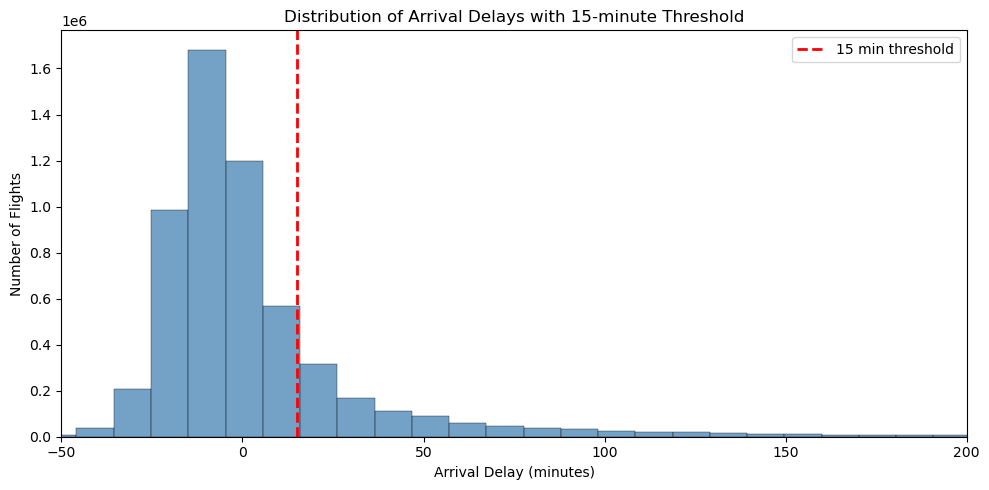

In [214]:

plt.figure(figsize=(10, 5))

sns.histplot(flights_df["ARRIVAL_DELAY"], bins=200, kde=False, color="steelblue")

plt.axvline(x=15, color="red", linestyle="--", linewidth=2, label="15 min threshold")

plt.xlim(-50, 200)  # optionnel, pour éviter les valeurs extrêmes
plt.xlabel("Arrival Delay (minutes)")
plt.ylabel("Number of Flights")
plt.title("Distribution of Arrival Delays with 15-minute Threshold")
plt.legend()
plt.tight_layout()
plt.show()


### Distribution of Delays Across the Calendar

To better understand how flight delays evolve over time, we analyze the delay rate
(i.e., the proportion of delayed flights) across three different temporal scales:
the day of the year, the day of the week, and the month. These visualizations help
reveal seasonal patterns, weekly trends, and operational behaviors affecting flight
punctuality.


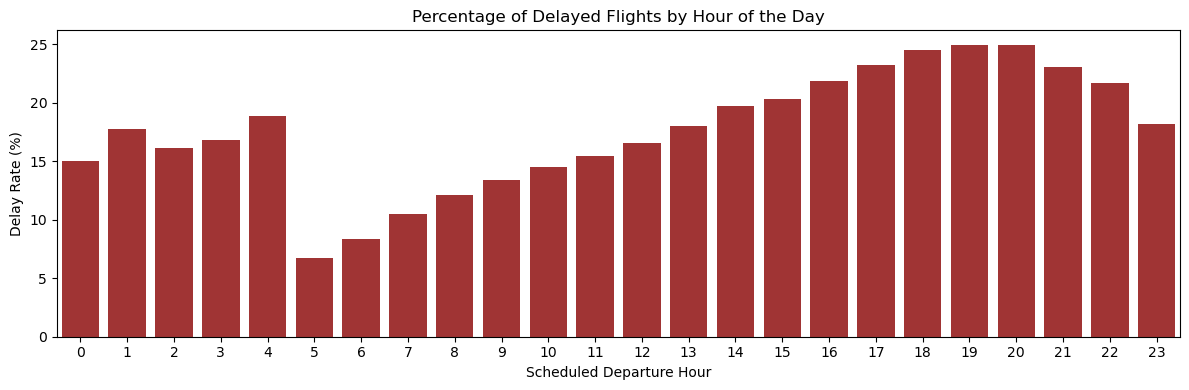

In [215]:

# Extract hour from scheduled departure (HHMM format)
flights_df["DEP_HOUR"] = flights_df["SCHEDULED_DEPARTURE"] // 100

# Compute delay rate per hour
delay_by_hour = flights_df.groupby("DEP_HOUR")["DELAYED"].mean() * 100

# Plot
plt.figure(figsize=(12, 4))
sns.barplot(x=delay_by_hour.index, y=delay_by_hour.values, color="firebrick")

plt.xlabel("Scheduled Departure Hour")
plt.ylabel("Delay Rate (%)")
plt.title("Percentage of Delayed Flights by Hour of the Day")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()



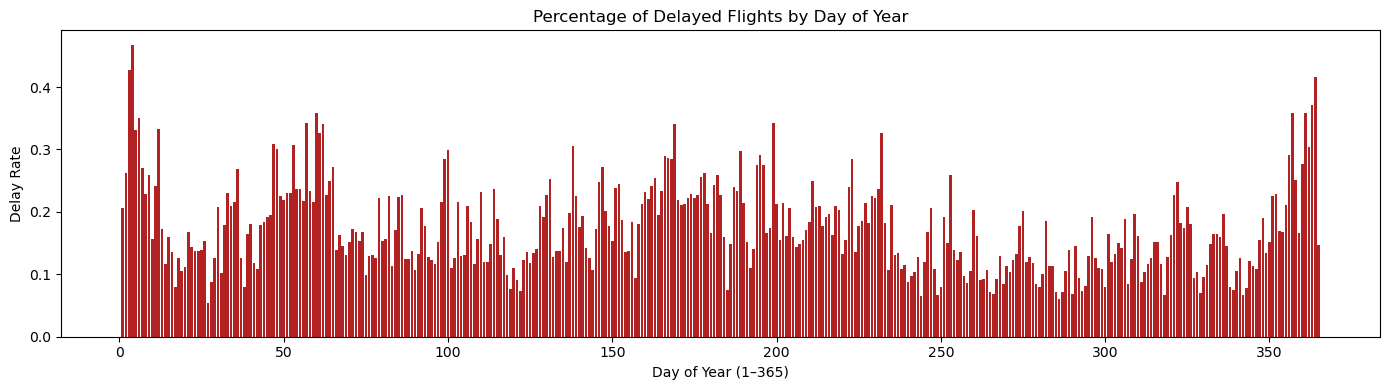

In [216]:

# Create proper datetime and extract day-of-year
flights_df["DATE"] = pd.to_datetime(flights_df[["YEAR", "MONTH", "DAY"]])
flights_df["DAY_OF_YEAR"] = flights_df["DATE"].dt.dayofyear

# Compute total flights and delayed flights per day
total_per_day = flights_df.groupby("DAY_OF_YEAR")["DELAYED"].count()
delayed_per_day = flights_df.groupby("DAY_OF_YEAR")["DELAYED"].sum()

# Compute normalized delay rate
delay_rate = delayed_per_day / total_per_day

# Plot bar chart
plt.figure(figsize=(14, 4))
plt.bar(delay_rate.index, delay_rate.values, color="firebrick")
plt.xlabel("Day of Year (1–365)")
plt.ylabel("Delay Rate")
plt.title("Percentage of Delayed Flights by Day of Year")
plt.tight_layout()
plt.show()


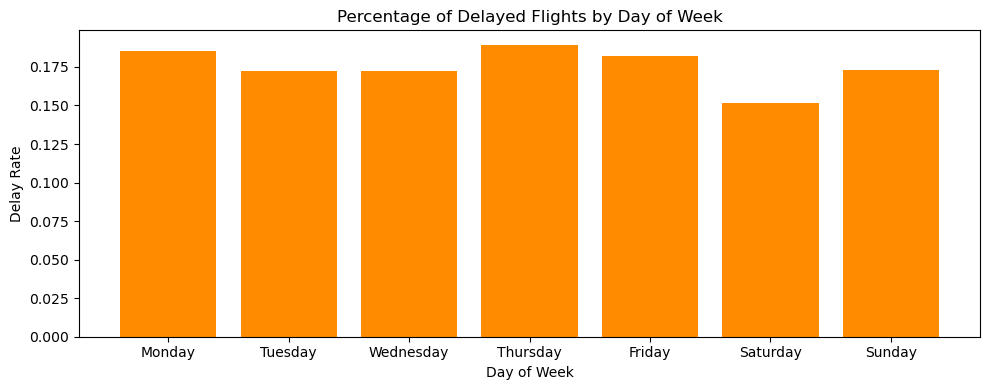

In [217]:

# Mapping DAY_OF_WEEK to labels
day_labels = {
    1: "Monday", 2: "Tuesday", 3: "Wednesday", 4: "Thursday",
    5: "Friday", 6: "Saturday", 7: "Sunday"
}

# Compute delay rate by day of week
delay_by_weekday = flights_df.groupby("DAY_OF_WEEK")["DELAYED"].mean()

plt.figure(figsize=(10, 4))
plt.bar(
    [day_labels[d] for d in delay_by_weekday.index],
    delay_by_weekday.values,
    color="darkorange"
)

plt.xlabel("Day of Week")
plt.ylabel("Delay Rate")
plt.title("Percentage of Delayed Flights by Day of Week")
plt.tight_layout()
plt.show()


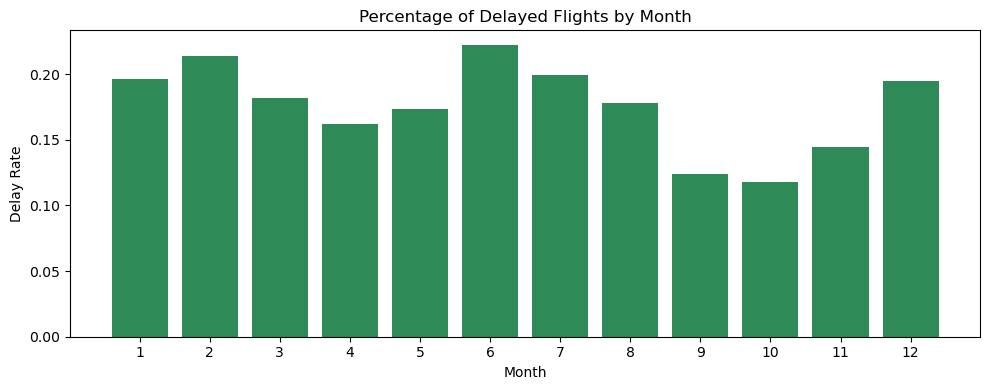

In [218]:

# Compute delay rate by month
delay_by_month = flights_df.groupby("MONTH")["DELAYED"].mean()

plt.figure(figsize=(10, 4))
plt.bar(delay_by_month.index, delay_by_month.values, color="seagreen")
plt.xlabel("Month")
plt.ylabel("Delay Rate")
plt.title("Percentage of Delayed Flights by Month")
plt.xticks(delay_by_month.index)
plt.tight_layout()
plt.show()


### Number of flights per airline

Using the flights dataset, we can count how many flights are associated with each airline, and visualize the distribution for the most active airlines.

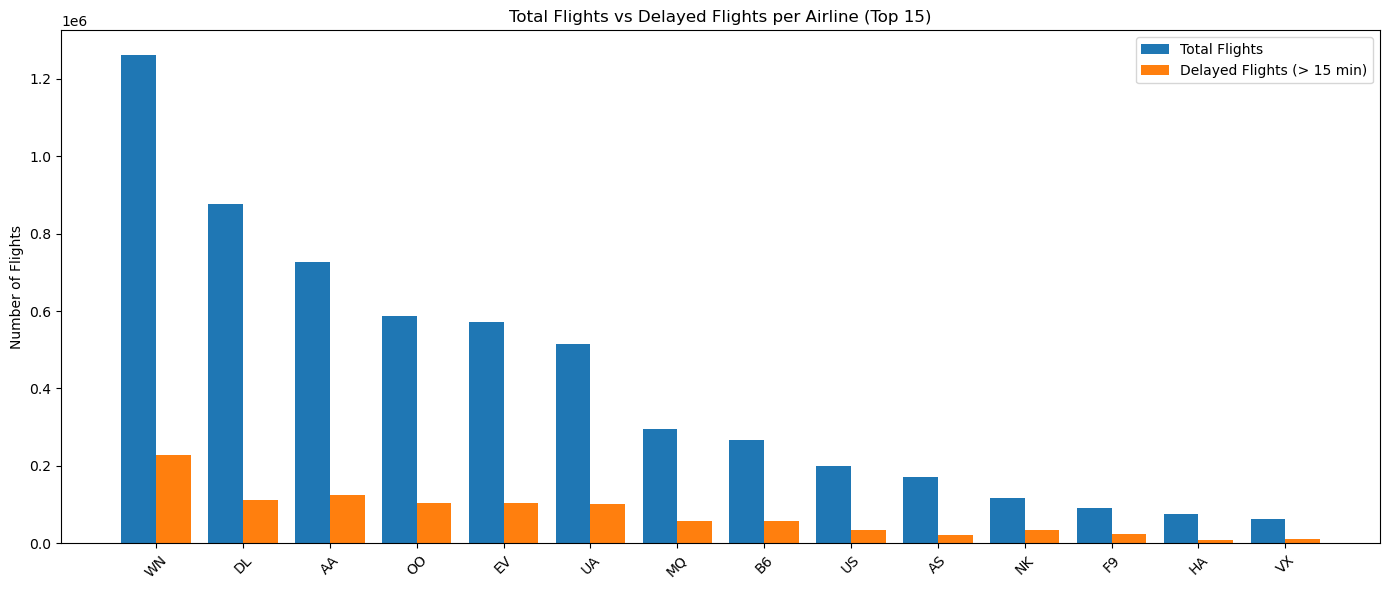

In [219]:

# Compute total flights per airline
total_flights = flights_df['AIRLINE'].value_counts()

# Compute delayed flights per airline
delayed_flights = flights_df[flights_df['DELAYED'] == 1]['AIRLINE'].value_counts()

# Align indexes (some airlines may not have delays)
aligned = pd.DataFrame({
    "TOTAL_FLIGHTS": total_flights,
    "DELAYED_FLIGHTS": delayed_flights
}).fillna(0).astype(int)

# Keep top 15 airlines by total flights
aligned_top15 = aligned.sort_values("TOTAL_FLIGHTS", ascending=False).head(15)

# Plot
plt.figure(figsize=(14,6))

bar_width = 0.4
x = range(len(aligned_top15))

plt.bar([i - bar_width/2 for i in x], aligned_top15["TOTAL_FLIGHTS"], 
        width=bar_width, label="Total Flights")
plt.bar([i + bar_width/2 for i in x], aligned_top15["DELAYED_FLIGHTS"], 
        width=bar_width, label="Delayed Flights (> 15 min)")

plt.xticks(x, aligned_top15.index, rotation=45)
plt.ylabel("Number of Flights")
plt.title("Total Flights vs Delayed Flights per Airline (Top 15)")
plt.legend()
plt.tight_layout()
plt.show()


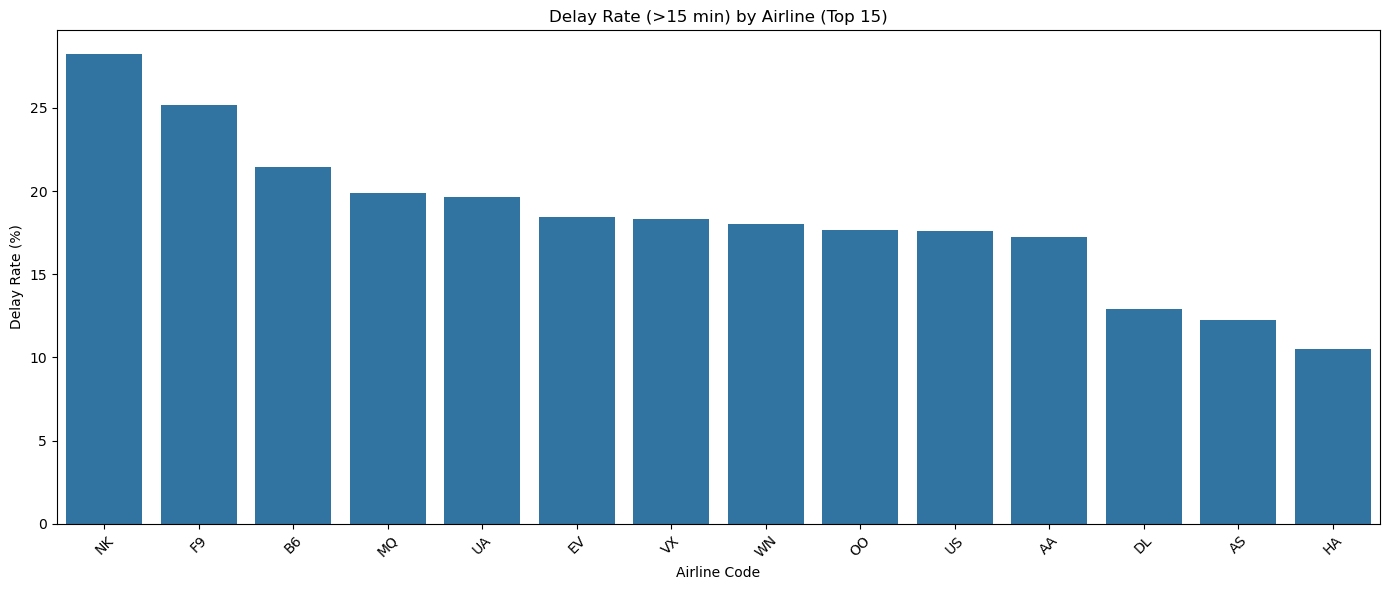

In [220]:
# Compute delay rate per airline
delay_rate = (aligned["DELAYED_FLIGHTS"] / aligned["TOTAL_FLIGHTS"]) * 100

# Top 15 by total flights
delay_rate_top15 = delay_rate.loc[aligned_top15.index]

# Sort descending
delay_rate_top15 = delay_rate_top15.sort_values(ascending=False)

# Plot delay rate
plt.figure(figsize=(14,6))
sns.barplot(x=delay_rate_top15.index, y=delay_rate_top15.values)

plt.title("Delay Rate (>15 min) by Airline (Top 15)")
plt.xlabel("Airline Code")
plt.ylabel("Delay Rate (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Number of Delay per Aiports

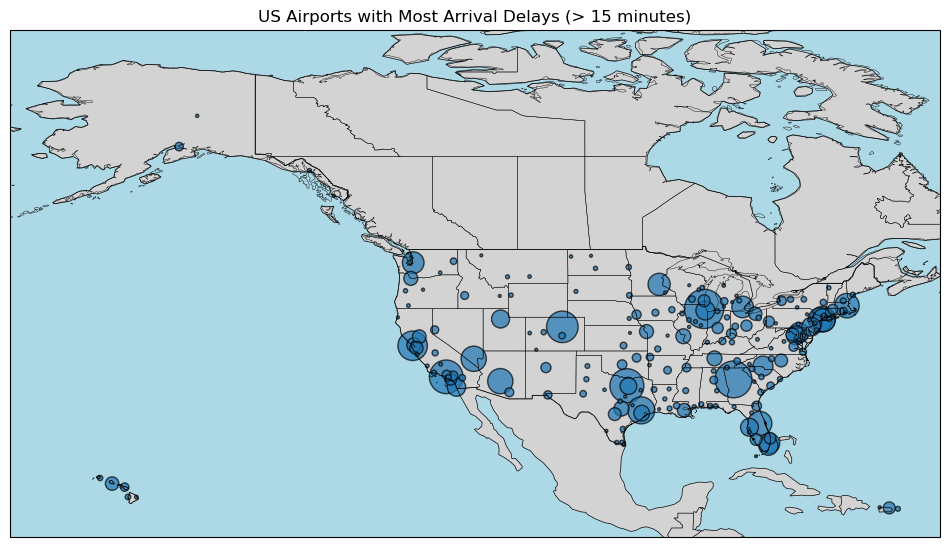

In [221]:
# 1. Compute number of delayed flights (> 15 min) per destination airport
delayed_flights = flights_df[flights_df["ARRIVAL_DELAY"] > 15]

delays_per_airport = (
    delayed_flights["DESTINATION_AIRPORT"]
    .value_counts()
    .rename("DELAY_COUNT")
    .to_frame()
)

# 2. Join with airports coordinates
airports_delay = airports_df.merge(
    delays_per_airport,
    left_on="IATA_CODE",
    right_index=True,
    how="inner"
)

# Option: keep only top 100 airports with most delays
top_airports_delay = airports_delay.sort_values("DELAY_COUNT", ascending=False).head(200)

# 3. Plot map of the US with airports as points
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Map extent roughly around the US (incl. Alaska & Hawaii)
ax.set_extent([-170, -60, 15, 75], crs=ccrs.PlateCarree())

# Add basic map features
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.STATES.with_scale("50m"), linewidth=0.3)

# 4. Scatter airports sized by number of delays
sizes = top_airports_delay["DELAY_COUNT"]  # raw counts
size_scaled = sizes / sizes.max() * 800    # scale for visibility

scatter = ax.scatter(
    top_airports_delay["LONGITUDE"],
    top_airports_delay["LATITUDE"],
    s=size_scaled,
    alpha=0.7,
    edgecolors="k",
    transform=ccrs.PlateCarree()
)

plt.title("US Airports with Most Arrival Delays (> 15 minutes)")
plt.show()


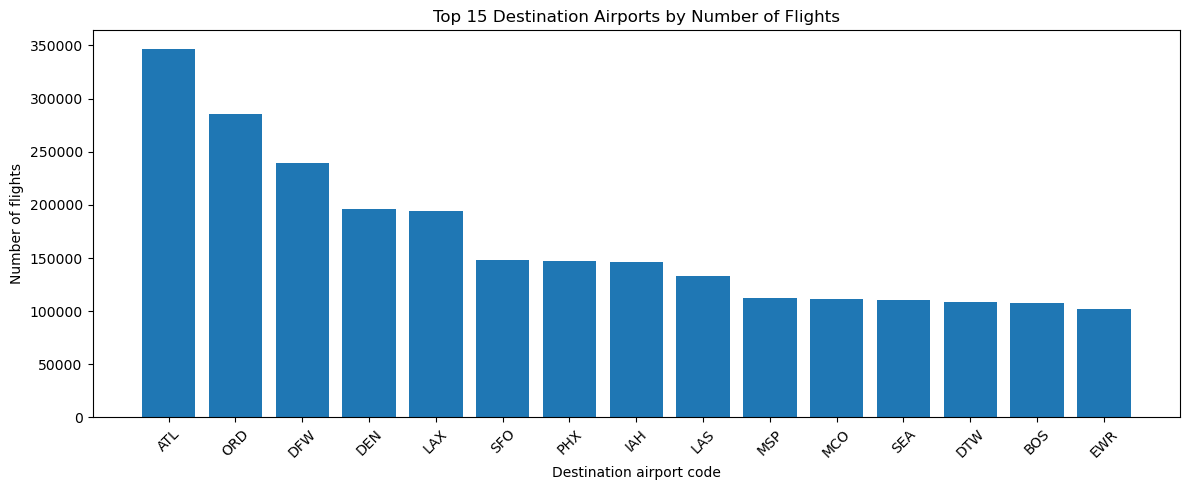

In [222]:
# Top 15 destination airports
top_dest = flights_df['DESTINATION_AIRPORT'].value_counts().head(15)

plt.figure(figsize=(12, 5))
plt.bar(top_dest.index, top_dest.values)
plt.title("Top 15 Destination Airports by Number of Flights")
plt.xlabel("Destination airport code")
plt.ylabel("Number of flights")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The largest clusters of delays appear on the East Coast, especially around the New York metropolitan area, Washington DC, and Boston. Significant concentrations also appear in major population centers such as Chicago, Atlanta, Dallas, Los Angeles, and San Francisco. These regions represent the most densely populated and trafficked parts of the United States. The correlation is clear: areas with higher population density and heavier air-traffic demand experience more delays. These airports operate near or at capacity, making them more vulnerable to congestion, weather events, and operational disruptions. The strong accumulation of delayed flights along the East Coast is consistent with the high urban density and complex air-traffic structure of this region.

### Delay rate by distance

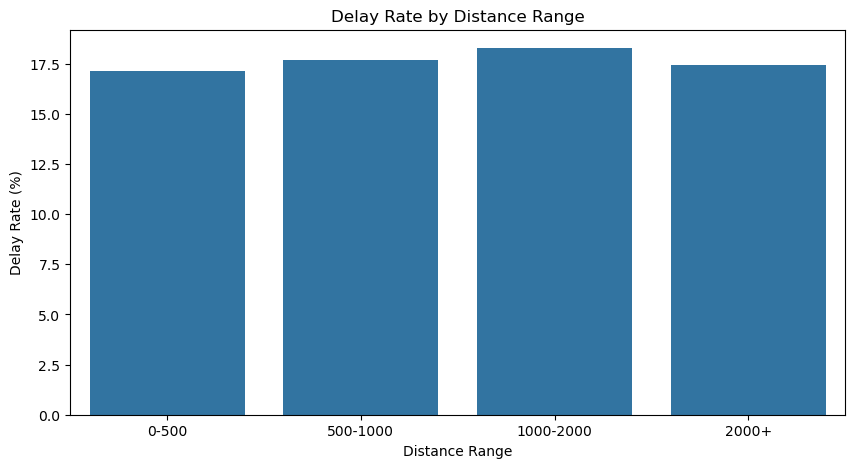

In [223]:

flights_df["DISTANCE_BIN"] = pd.cut(
    flights_df["DISTANCE"],
    bins=[0, 500, 1000, 2000, 5000],
    labels=["0-500", "500-1000", "1000-2000", "2000+"]
)

delay_by_distance = flights_df.groupby("DISTANCE_BIN")["DELAYED"].mean() * 100

plt.figure(figsize=(10,5))
sns.barplot(x=delay_by_distance.index, y=delay_by_distance.values)
plt.title("Delay Rate by Distance Range")
plt.xlabel("Distance Range")
plt.ylabel("Delay Rate (%)")
plt.show()


### 3. Airlines dataset

We briefly inspect the airlines reference table>.


In [224]:

airlines_df.head(20)


,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


### AIrlines shape

In [225]:

airlines_df.shape


(14, 2)

### Columns and data types

In [226]:

airlines_df.dtypes.to_frame(name="dtype")


,dtype
IATA_CODE,object
AIRLINE,object


### Checking missing values and duplicates

In [227]:

airlines_df.isna().sum()


IATA_CODE    0
AIRLINE      0
dtype: int64

In [228]:

# Count duplicates
num_duplicates = airlines_df.duplicated().sum()

print(f"Number of duplicate rows in airlines_df: {num_duplicates}")

# Show first duplicates if any
if num_duplicates > 0:
    print("\nSample duplicated rows:")
    display(airlines_df[airlines_df.duplicated()].head())
else:
    print("\nNo duplicate rows found.")


Number of duplicate rows in airlines_df: 0

No duplicate rows found.


### 4. Airports dataset

We also inspect the airports table, which describes origin and destination airports.


In [229]:

airports_df.head()


,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


### Airports shape

In [230]:

airports_df.shape


(322, 7)

### Columns and data types

In [231]:

airports_df.dtypes.to_frame(name="dtype")


,dtype
IATA_CODE,object
AIRPORT,object
CITY,object
STATE,object
COUNTRY,object
LATITUDE,float64
LONGITUDE,float64


### Checking missing values and duplicates

In [232]:

display(airports_df.isna().sum())


IATA_CODE    0
AIRPORT      0
CITY         0
STATE        0
COUNTRY      0
LATITUDE     3
LONGITUDE    3
dtype: int64

In [233]:

# Count duplicates
num_duplicates = airports_df.duplicated().sum()

print(f"Number of duplicate rows in airports_df: {num_duplicates}")

# Show first duplicates if any
if num_duplicates > 0:
    print("\nSample duplicated rows:")
    display(airports_df[airports_df.duplicated()].head())
else:
    print("\nNo duplicate rows found.")


Number of duplicate rows in airports_df: 0

No duplicate rows found.


In [234]:

# All unique airports appearing in flights_df
flight_airports = set(flights_df['ORIGIN_AIRPORT']).union(
    set(flights_df['DESTINATION_AIRPORT'])
)

# All airports available in airports_df
airport_reference = set(airports_df['IATA_CODE'])

# Airports used in flights_df but missing from airports_df
unknown_airports = sorted(list(flight_airports - airport_reference))

print(f"Total airports in flights_df: {len(flight_airports)}")
print(f"Airports in airports_df: {len(airport_reference)}")
print(f"Airports missing from airports_df: {len(unknown_airports)}")


Total airports in flights_df: 629
Airports in airports_df: 322
Airports missing from airports_df: 307


In [235]:
# Count flights where ORIGIN or DESTINATION airport is missing in airports_df
missing_origin_mask = flights_df['ORIGIN_AIRPORT'].isin(unknown_airports)
missing_dest_mask   = flights_df['DESTINATION_AIRPORT'].isin(unknown_airports)

# Flights impacted (either origin or destination missing)
impacted_flights_mask = missing_origin_mask | missing_dest_mask

num_impacted = impacted_flights_mask.sum()
total_flights = len(flights_df)

print(f"Number of flights impacted by missing airports: {num_impacted}")
print(f"Percentage of total flights: {num_impacted / total_flights * 100:.2f}%")


Number of flights impacted by missing airports: 486165
Percentage of total flights: 8.35%


In [236]:

# Identify airports missing key geographical data
missing_geo = airports_df[
    airports_df[['LATITUDE', 'LONGITUDE']].isna().any(axis=1)
]

print(f"\nNumber of airports missing latitude or longitude: {missing_geo.shape[0]}")
print(f"Percentage of airports affected: {100 * missing_geo.shape[0] / airports_df.shape[0]:.2f}%")

# Display the affected airports
if missing_geo.shape[0] > 0:
    display(missing_geo[['IATA_CODE', 'AIRPORT', 'CITY', 'STATE', 'LATITUDE', 'LONGITUDE']])
else:
    print("No airports with missing coordinates.")
    


Number of airports missing latitude or longitude: 3
Percentage of airports affected: 0.93%


,IATA_CODE,AIRPORT,CITY,STATE,LATITUDE,LONGITUDE
96,ECP,Northwest Florida Beaches International Airport,Panama City,FL,NaN,NaN
234,PBG,Plattsburgh International Airport,Plattsburgh,NY,NaN,NaN
313,UST,Northeast Florida Regional Airport (St. August...,St. Augustine,FL,NaN,NaN


In [237]:

# List of airport codes missing LAT/LON from the previous analysis
missing_airport_codes = missing_geo['IATA_CODE'].unique()

# Flights where ORIGIN_AIRPORT is missing coordinates
flights_missing_origin = flights_df[
    flights_df['ORIGIN_AIRPORT'].isin(missing_airport_codes)
]

# Flights where DESTINATION_AIRPORT is missing coordinates
flights_missing_dest = flights_df[
    flights_df['DESTINATION_AIRPORT'].isin(missing_airport_codes)
]

# Total affected flights (union of both)
flights_missing_coords = pd.concat([
    flights_missing_origin, 
    flights_missing_dest
]).drop_duplicates()

print("\nNumber of flights missing origin coordinates:", flights_missing_origin.shape[0])
print("Number of flights missing destination coordinates:", flights_missing_dest.shape[0])
print("Total unique affected flights:", flights_missing_coords.shape[0])
print(f"Percentage of affected flights: {100 * flights_missing_coords.shape[0] / flights_df.shape[0]:.3f}%")


# Flights where ORIGIN_AIRPORT is missing coordinates
flights_missing_origin = flights_df[
    flights_df['ORIGIN_AIRPORT'].isin(missing_airport_codes)
]

# Flights where DESTINATION_AIRPORT is missing coordinates
flights_missing_dest = flights_df[
    flights_df['DESTINATION_AIRPORT'].isin(missing_airport_codes)
]

# Total affected flights (union of both)
flights_missing_coords = pd.concat([
    flights_missing_origin, 
    flights_missing_dest
]).drop_duplicates()

print("\nNumber of flights missing origin coordinates:", flights_missing_origin.shape[0])
print("Number of flights missing destination coordinates:", flights_missing_dest.shape[0])
print("Total unique affected flights:", flights_missing_coords.shape[0])
print(f"Percentage of affected flights: {100 * flights_missing_coords.shape[0] / flights_df.shape[0]:.3f}%")



Number of flights missing origin coordinates: 4605
Number of flights missing destination coordinates: 4610
Total unique affected flights: 9215
Percentage of affected flights: 0.158%

Number of flights missing origin coordinates: 4605
Number of flights missing destination coordinates: 4610
Total unique affected flights: 9215
Percentage of affected flights: 0.158%


------

## **III. Data Pre-Processing - Features Engineering**

### 1. Data Cleaning
#### **Removal of non-informative features**

Some variables are not useful for the prediction task or are only used for data filtering and descriptive analysis.  
They are removed from the feature set to simplify the dataset:

- **YEAR**: All flights are from 2015 in this dataset, so this variable does not bring additional information.
- **DIVERTED**: Indicates whether the flight was diverted. This is a special operational case that is not part of the standard delay prediction target.
- **CANCELLED**: Indicates whether the flight was cancelled. Cancelled flights are usually excluded from arrival delay prediction, as they do not have a valid arrival delay.
- **CANCELLATION_REASON**: Describes the reason for cancellation, but cancelled flights will not be used as standard samples for arrival delay prediction.

These columns are therefore dropped from the feature set.

In [14]:

cols_useless = [
    'YEAR',
    'DIVERTED',
    'CANCELLED',
    'CANCELLATION_REASON'
]

# Check if all columns exist in the dataset
missing_columns = [col for col in cols_useless if col not in flights_df.columns]
if missing_columns:
    print(f"\n⚠️ Warning: The following columns were not found in the dataset:")
    for col in missing_columns:
        print(f"  - {col}")

flights_df = flights_df.drop(columns=cols_useless, errors='ignore')


#### **Removal of high-cardinality identifier variables**

The dataset contains two identifier-like variables:

- **FLIGHT_NUMBER** (6,952 unique values)
- **TAIL_NUMBER** (4,897 unique values)
 
Encoding them would increase dimensionality resulting in a sparse and inefficient feature space.

Using these identifiers typically leads modelsto overfit on the training data, producing predictions that do not generalize to unseen flights or aircraft.

For these reasons, both variables are removed from the dataset before training any model.


In [15]:

cols_to_drop_id = ['FLIGHT_NUMBER', 'TAIL_NUMBER']
flights_df = flights_df.drop(columns=cols_to_drop_id, errors='ignore')


#### **Removal of leakage features**

Several variables contain information that is only available after the flight has departed or after it has landed.  
Using them would create a non-realistic model (data leakage).  
They must be removed before training:

- **ARRIVAL_DELAY**: Actual delay of the aircraft, only known after the flight is over.
- **DEPARTURE_TIME**: Actual departure time, only known after the aircraft has departed.
- **DEPARTURE_DELAY**: Actual departure delay. Using it to predict arrival delay would directly inject the target information.
- **TAXI_OUT**: Actual taxi-out time before take-off, measured after the plane leaves the gate.
- **WHEELS_OFF**: Time when the aircraft actually leaves the ground.
- **ELAPSED_TIME**: Actual total flight time.
- **AIR_TIME**: Actual time spent in the air, known only after landing.
- **WHEELS_ON**: Time when the aircraft touches down on arrival.
- **TAXI_IN**: Taxi-in time after landing, measured post-flight.
- **ARRIVAL_TIME**: Actual arrival time, directly linked to the true delay.
- **AIR_SYSTEM_DELAY**: Delay attributed to the air traffic system.
- **SECURITY_DELAY**: Delay attributed to security issues.
- **AIRLINE_DELAY**: Delay attributed to the airline.
- **LATE_AIRCRAFT_DELAY**: Delay due to the late arrival of the previous aircraft.
- **WEATHER_DELAY**: Delay attributed to weather conditions.

All these variables are removed from the feature set to avoid data leakage.

In [16]:
# Drop variables that cause data leakage
cols_leakage = [
    'DEPARTURE_TIME',
    'ARRIVAL_DELAY',
    'DEPARTURE_DELAY',
    'TAXI_OUT',
    'WHEELS_OFF',
    'ELAPSED_TIME',
    'AIR_TIME',
    'WHEELS_ON',
    'TAXI_IN',
    'ARRIVAL_TIME',
    'AIR_SYSTEM_DELAY',
    'SECURITY_DELAY',
    'AIRLINE_DELAY',
    'LATE_AIRCRAFT_DELAY',
    'WEATHER_DELAY'
]

# Check if all columns exist in the dataset
missing_columns = [col for col in cols_leakage if col not in flights_df.columns]
if missing_columns:
    print(f"\n⚠️ Warning: The following columns were not found in the dataset:")
    for col in missing_columns:
        print(f"  - {col}")

flights_df = flights_df.drop(columns=cols_leakage, errors='ignore')


### 2. Features Engineering

#### a) Time Feature Engineering (Departure & Arrival)

Both `SCHEDULED_DEPARTURE` and `SCHEDULED_ARRIVAL` are encoded in `HHMM` integer format  
(e.g., `5 → 00:05`, `700 → 07:00`, `2215 → 22:15`).  
Machine learning algorithms cannot interpret these values because time is a **cyclic** variable  
(23:00 is very close to 00:00, but numerically 23 and 0 are far apart).

To obtain meaningful features we:

1. Converted each time into a `HHMM` string.
2. Extracted the hour and minute.
3. Converted the time into total minutes since midnight.
4. Applied cyclic encoding using sine and cosine:
   - `TIME_SIN = sin(2π * total_minutes / 1440)`
   - `TIME_COS = cos(2π * total_minutes / 1440)`

This encoding correctly preserves the circular nature of time and improves the interpretability and the performance of the models.  
The original `SCHEDULED_DEPARTURE` and `SCHEDULED_ARRIVAL` are removed after the transformation.



In [17]:
def encode_time_column(df, col_name, prefix):
    """
    Convert HHMM integer time into hour, minute, cyclic encoding.
    Creates columns:
        prefix_HOUR, prefix_MINUTE, prefix_TOTAL_MIN,
        prefix_SIN, prefix_COS
    """
    # Zero-padded HHMM strings
    t_str = df[col_name].astype(str).str.zfill(4)

    # Extract hour and minute
    df[f"{prefix}_HOUR"] = t_str.str[:2].astype(int)
    df[f"{prefix}_MINUTE"] = t_str.str[2:].astype(int)

    # Total minutes since midnight
    df[f"{prefix}_TOTAL_MIN"] = df[f"{prefix}_HOUR"] * 60 + df[f"{prefix}_MINUTE"]

    # Cyclic encoding
    df[f"{prefix}_SIN"] = np.sin(2 * np.pi * df[f"{prefix}_TOTAL_MIN"] / 1440)
    df[f"{prefix}_COS"] = np.cos(2 * np.pi * df[f"{prefix}_TOTAL_MIN"] / 1440)


# Encode both scheduled times
encode_time_column(flights_df, "SCHEDULED_DEPARTURE", "DEP")
encode_time_column(flights_df, "SCHEDULED_ARRIVAL", "ARR")

# Drop original columns
flights_df = flights_df.drop(columns=["SCHEDULED_DEPARTURE", "SCHEDULED_ARRIVAL"])

flights_df.head()


,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_TIME,DISTANCE,DELAYED,DEP_HOUR,DEP_MINUTE,DEP_TOTAL_MIN,DEP_SIN,DEP_COS,ARR_HOUR,ARR_MINUTE,ARR_TOTAL_MIN,ARR_SIN,ARR_COS
0,1,1,4,AS,ANC,SEA,205.0,1448,0,0,5,5,0.021815,0.999762,4,30,270,0.923880,0.382683
1,1,1,4,AA,LAX,PBI,280.0,2330,0,0,10,10,0.043619,0.999048,7,50,470,0.887011,-0.461749
2,1,1,4,US,SFO,CLT,286.0,2296,0,0,20,20,0.087156,0.996195,8,6,486,0.852640,-0.522499
3,1,1,4,AA,LAX,MIA,285.0,2342,0,0,20,20,0.087156,0.996195,8,5,485,0.854912,-0.518773
4,1,1,4,AS,SEA,ANC,235.0,1448,0,0,25,25,0.108867,0.994056,3,20,200,0.766044,0.642788


The intermediate features (`HOUR`, `MINUTE`, `TOTAL_MIN`) are not needed anymore and are removed

In [18]:

time_cols_to_drop = [
    'DEP_HOUR', 'DEP_MINUTE', 'DEP_TOTAL_MIN',
    'ARR_HOUR', 'ARR_MINUTE', 'ARR_TOTAL_MIN'
]

# Check if all columns exist in the dataset
missing_columns = [col for col in time_cols_to_drop if col not in flights_df.columns]
if missing_columns:
    print(f"\n⚠️ Warning: The following columns were not found in the dataset:")
    for col in missing_columns:
        print(f"  - {col}")


flights_df = flights_df.drop(columns=time_cols_to_drop, errors='ignore')
flights_df.head()


,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_TIME,DISTANCE,DELAYED,DEP_SIN,DEP_COS,ARR_SIN,ARR_COS
0,1,1,4,AS,ANC,SEA,205.0,1448,0,0.021815,0.999762,0.923880,0.382683
1,1,1,4,AA,LAX,PBI,280.0,2330,0,0.043619,0.999048,0.887011,-0.461749
2,1,1,4,US,SFO,CLT,286.0,2296,0,0.087156,0.996195,0.852640,-0.522499
3,1,1,4,AA,LAX,MIA,285.0,2342,0,0.087156,0.996195,0.854912,-0.518773
4,1,1,4,AS,SEA,ANC,235.0,1448,0,0.108867,0.994056,0.766044,0.642788


#### b) Airport feature engineering (geographical encoding)

The variables `ORIGIN_AIRPORT` and `DESTINATION_AIRPORT` are a 3-letter IATA airport codes.

We build a **route feature**. For each route, we compute the total number of flights operated on that pair in 2015.  
This **route frequency** is then used as a single numeric feature:

- `ROUTE_COUNT` = number of flights for a given `(ORIGIN_AIRPORT, DESTINATION_AIRPORT)`.

This encoding captures route popularity and traffic intensity which are related to delays. 

In [19]:

# Build a route identifier 
flights_df['ROUTE'] = flights_df['ORIGIN_AIRPORT'] + "_" + flights_df['DESTINATION_AIRPORT']

# Compute route frequencies
route_counts = flights_df['ROUTE'].value_counts()

# Map route frequencies back to the main dataframe
flights_df['ROUTE_COUNT'] = flights_df['ROUTE'].map(route_counts)

# Drop the intermediate ROUTE string column (not used as a feature)
flights_df = flights_df.drop(columns=['ROUTE'])

flights_df.head()



,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_TIME,DISTANCE,DELAYED,DEP_SIN,DEP_COS,ARR_SIN,ARR_COS,ROUTE_COUNT
0,1,1,4,AS,ANC,SEA,205.0,1448,0,0.021815,0.999762,0.923880,0.382683,6383
1,1,1,4,AA,LAX,PBI,280.0,2330,0,0.043619,0.999048,0.887011,-0.461749,77
2,1,1,4,US,SFO,CLT,286.0,2296,0,0.087156,0.996195,0.852640,-0.522499,1818
3,1,1,4,AA,LAX,MIA,285.0,2342,0,0.087156,0.996195,0.854912,-0.518773,3023
4,1,1,4,AS,SEA,ANC,235.0,1448,0,0.108867,0.994056,0.766044,0.642788,6382


#### c) Airline handling

The column `AIRLINE` contains the airline IATA code ("AA", "DL", "UA").  
Since the number of categories is small, this variable will be handled directly in the pipeline using `OneHotEncoder` from sklearn.


#### **Removing rows with missing values**

After completing all feature engineering steps, we remove any rows containing missing values.
Cleaning them here ensures a consistent dataset before splitting into train and test sets.



In [20]:

missing_values = flights_df.isna().sum()
missing_percentage = (missing_values / len(flights_df)) * 100

missing_df = pd.DataFrame({
    "Column": missing_values.index,
    "Missing_Count": missing_values.values,
    "Missing_Percentage": missing_percentage.values
}).query("Missing_Count > 0").sort_values("Missing_Count", ascending=False)

missing_df

flights_df = flights_df.dropna()


---


## **IV. Baseline Models**

In this section, we train and evaluate four baseline models on the imbalanced dataset:

- Logistic Regression  
- Decision Tree  
- Random Forest  
- XGBoost  


In [21]:
# Target variable
y = flights_df['DELAYED']

# Feature matrix: drop target, raw delay and raw airport codes
X = flights_df.drop(
    columns=['DELAYED', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT'],
    errors='ignore'
)

# Categorical features
categorical_features = ['AIRLINE']

# All numeric columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Check
print("Categorical features:", categorical_features)
print("Numeric features:", numeric_features)


Categorical features: ['AIRLINE']
Numeric features: ['MONTH', 'DAY', 'DAY_OF_WEEK', 'SCHEDULED_TIME', 'DISTANCE', 'DEP_SIN', 'DEP_COS', 'ARR_SIN', 'ARR_COS', 'ROUTE_COUNT']


In [22]:
X.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,SCHEDULED_TIME,DISTANCE,DEP_SIN,DEP_COS,ARR_SIN,ARR_COS,ROUTE_COUNT
0,1,1,4,AS,205.0,1448,0.021815,0.999762,0.923880,0.382683,6383
1,1,1,4,AA,280.0,2330,0.043619,0.999048,0.887011,-0.461749,77
2,1,1,4,US,286.0,2296,0.087156,0.996195,0.852640,-0.522499,1818
3,1,1,4,AA,285.0,2342,0.087156,0.996195,0.854912,-0.518773,3023
4,1,1,4,AS,235.0,1448,0.108867,0.994056,0.766044,0.642788,6382


In [53]:

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ]
)

# Model pipelines
models = {
    "LogReg": Pipeline([
        ('preprocess', preprocessor),
        ('clf', LogisticRegression(max_iter=500))
    ]),
    
    "DecisionTree": Pipeline([
        ('preprocess', preprocessor),
        ('clf', DecisionTreeClassifier(random_state=42))
    ]),
    
    "RandomForest": Pipeline([
        ('preprocess', preprocessor),
        ('clf', RandomForestClassifier(
            n_estimators=100,      
        max_depth=15,          
        min_samples_split=200,
        min_samples_leaf=50,
        max_features='sqrt',  
        max_samples=0.5, 
        n_jobs=-1,
        random_state=42
        ))
    ]),
    
    "XGBoost": Pipeline([
        ('preprocess', preprocessor),
        ('clf', XGBClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            eval_metric='logloss',
            n_jobs=-1
        ))
    ])
}


### **1. Logistic Regression**

In [54]:

logreg_model = Pipeline([
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(max_iter=500))
])

start = time.time()
logreg_model.fit(X_train, y_train)

y_pred_lr = logreg_model.predict(X_test)
y_proba_lr = logreg_model.predict_proba(X_test)[:, 1]
logreg_train_time = time.time() - start


logreg_results = {
    "Accuracy": accuracy_score(y_test, y_pred_lr),
    "Precision": precision_score(y_test, y_pred_lr),
    "Recall": recall_score(y_test, y_pred_lr),
    "F1": f1_score(y_test, y_pred_lr),
    "ROC-AUC": roc_auc_score(y_test, y_proba_lr),
    "Train_time_s": logreg_train_time
}

print("=== Logistic Regression ===")
print("Training Time :", logreg_results["Train_time_s"])
print("Accuracy :", logreg_results["Accuracy"])
print("Precision:", logreg_results["Precision"])
print("Recall   :", logreg_results["Recall"])
print("F1-score :", logreg_results["F1"])
print("ROC-AUC  :", logreg_results["ROC-AUC"])

print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))


=== Logistic Regression ===
Training Time : 8.46408724784851
Accuracy : 0.8241137981552051
Precision: 1.0
Recall   : 4.885197850512946e-06
F1-score : 9.770347970942985e-06
ROC-AUC  : 0.630398019388095

Classification Report:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90    959115
           1       1.00      0.00      0.00    204700

    accuracy                           0.82   1163815
   macro avg       0.91      0.50      0.45   1163815
weighted avg       0.86      0.82      0.74   1163815



### **2. Decision Tree**

In [55]:

dt_model = Pipeline([
    ('preprocess', preprocessor),
    ('clf', DecisionTreeClassifier(random_state=42))
])

start = time.time()
dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)
y_proba_dt = dt_model.predict_proba(X_test)[:, 1]
dt_train_time = time.time() - start

dt_results = {
    "Accuracy": accuracy_score(y_test, y_pred_dt),
    "Precision": precision_score(y_test, y_pred_dt),
    "Recall": recall_score(y_test, y_pred_dt),
    "F1": f1_score(y_test, y_pred_dt),
    "ROC-AUC": roc_auc_score(y_test, y_proba_dt),
    "Train_time_s": dt_train_time
}


In [56]:
print("=== Decision Tree ===")
print("Training Time :", dt_results["Train_time_s"])
print("Accuracy :", dt_results["Accuracy"])
print("Precision:", dt_results["Precision"])
print("Recall   :", dt_results["Recall"])
print("F1-score :", dt_results["F1"])
print("ROC-AUC  :", dt_results["ROC-AUC"])

print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))

=== Decision Tree ===
Training Time : 84.97838187217712
Accuracy : 0.7451648243062686
Precision: 0.29188052967051886
Recall   : 0.3147532975085491
F1-score : 0.30288571153226884
ROC-AUC  : 0.5758981446371387

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.84    959115
           1       0.29      0.31      0.30    204700

    accuracy                           0.75   1163815
   macro avg       0.57      0.58      0.57   1163815
weighted avg       0.75      0.75      0.75   1163815



### **3. Random Forest**

In [57]:

rf_model = Pipeline([
    ('preprocess', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])

start = time.time()
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
rf_train_time = time.time() - start

rf_results = {
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf),
    "Recall": recall_score(y_test, y_pred_rf),
    "F1": f1_score(y_test, y_pred_rf),
    "ROC-AUC": roc_auc_score(y_test, y_proba_rf),
    "Train_time_s": rf_train_time
}


In [59]:
print("=== RandomForest ===")
print("Training Time :", rf_results["Train_time_s"])
print("Accuracy :", rf_results["Accuracy"])
print("Precision:", rf_results["Precision"])
print("Recall   :", rf_results["Recall"])
print("F1-score :", rf_results["F1"])
print("ROC-AUC  :", rf_results["ROC-AUC"])

print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


=== RandomForest ===
Training Time : 1235.1018588542938
Accuracy : 0.8211846384519876
Precision: 0.47225569051418154
Recall   : 0.141695163654128
F1-score : 0.2179860062077725
ROC-AUC  : 0.6959709014310463

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.97      0.90    959115
           1       0.47      0.14      0.22    204700

    accuracy                           0.82   1163815
   macro avg       0.66      0.55      0.56   1163815
weighted avg       0.78      0.82      0.78   1163815



### **4. XGBoost**

In [60]:

xgb_model = Pipeline([
    ('preprocess', preprocessor),
    ('clf', XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss',
        n_jobs=-1
    ))
])

start = time.time()
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
xgb_train_time = time.time() - start

xgb_results = {
    "Accuracy": accuracy_score(y_test, y_pred_xgb),
    "Precision": precision_score(y_test, y_pred_xgb),
    "Recall": recall_score(y_test, y_pred_xgb),
    "F1": f1_score(y_test, y_pred_xgb),
    "ROC-AUC": roc_auc_score(y_test, y_proba_xgb),
    "Train_time_s": xgb_train_time
}

print("=== XGBoost ===")
print("Training Time :", xgb_results["Train_time_s"])
print("Accuracy :", xgb_results["Accuracy"])
print("Precision:", xgb_results["Precision"])
print("Recall   :", xgb_results["Recall"])
print("F1-score :", xgb_results["F1"])
print("ROC-AUC  :", xgb_results["ROC-AUC"])

print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))



=== XGBoost ===
Training Time : 45.71164274215698
Accuracy : 0.8262593281578258
Precision: 0.647253006366423
Recall   : 0.02681973619931607
F1-score : 0.051505286562655385
ROC-AUC  : 0.7039977222962075

Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.90    959115
           1       0.65      0.03      0.05    204700

    accuracy                           0.83   1163815
   macro avg       0.74      0.51      0.48   1163815
weighted avg       0.80      0.83      0.75   1163815



### **5. Model Performance Comparison**

In [62]:

results_df = pd.DataFrame({
    "LogReg": logreg_results,
    "DecisionTree": dt_results,
    "RandomForest": rf_results,
    "XGBoost": xgb_results
}).T

results_df


,Accuracy,Precision,Recall,F1,ROC-AUC,Train_time_s
LogReg,0.824114,1.000000,0.000005,0.000010,0.630398,8.464087
DecisionTree,0.745165,0.291881,0.314753,0.302886,0.575898,84.978382
RandomForest,0.821185,0.472256,0.141695,0.217986,0.695971,1235.101859
XGBoost,0.826259,0.647253,0.026820,0.051505,0.703998,45.711643


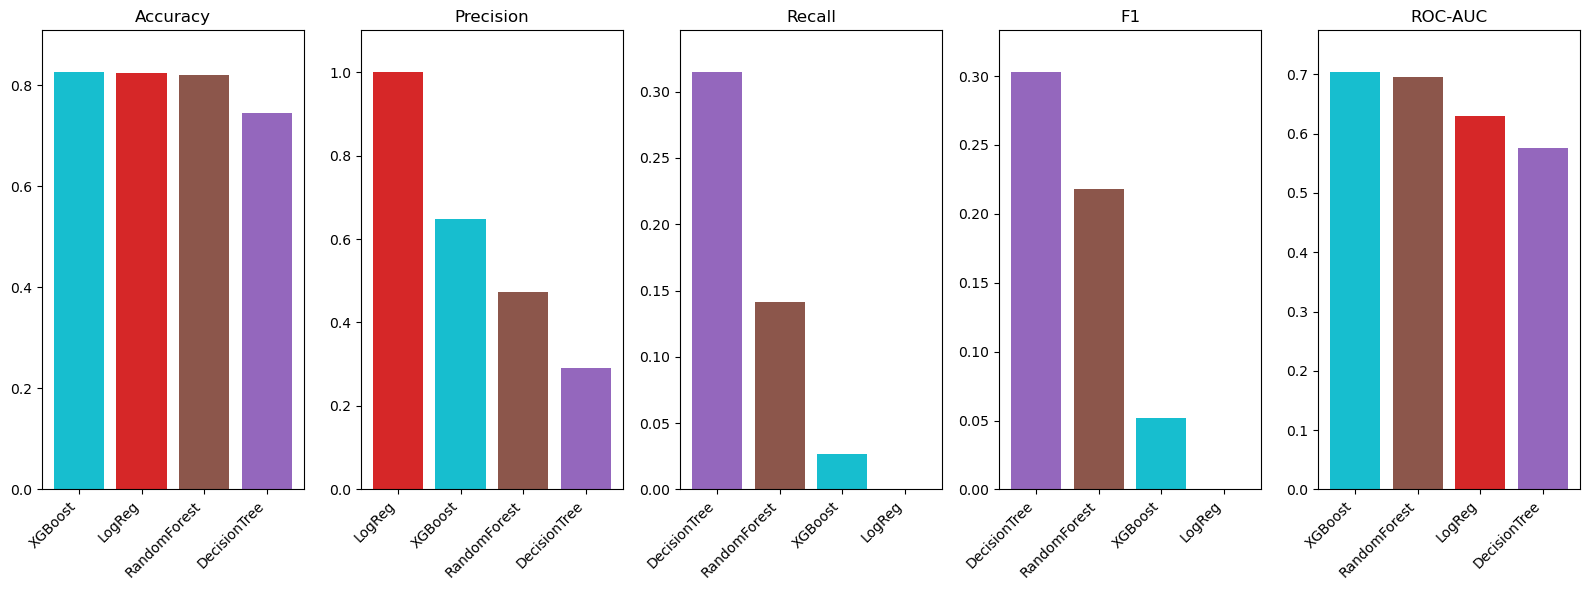

In [108]:

metrics = ["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"]
model_names = results_df.index.tolist()
data = results_df[metrics].values

plt.figure(figsize=(16, 6))

for i, metric in enumerate(metrics):
    metric_values = data[:, i]
    sorted_idx = np.argsort(metric_values)[::-1]
    sorted_vals = metric_values[sorted_idx]
    sorted_labels = [model_names[j] for j in sorted_idx]

    plt.subplot(1, len(metrics), i+1)
    plt.bar(sorted_labels, sorted_vals,
            color=[colors[label] for label in sorted_labels])
    
    plt.title(metric)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, max(sorted_vals) * 1.1)

plt.tight_layout()
plt.show()



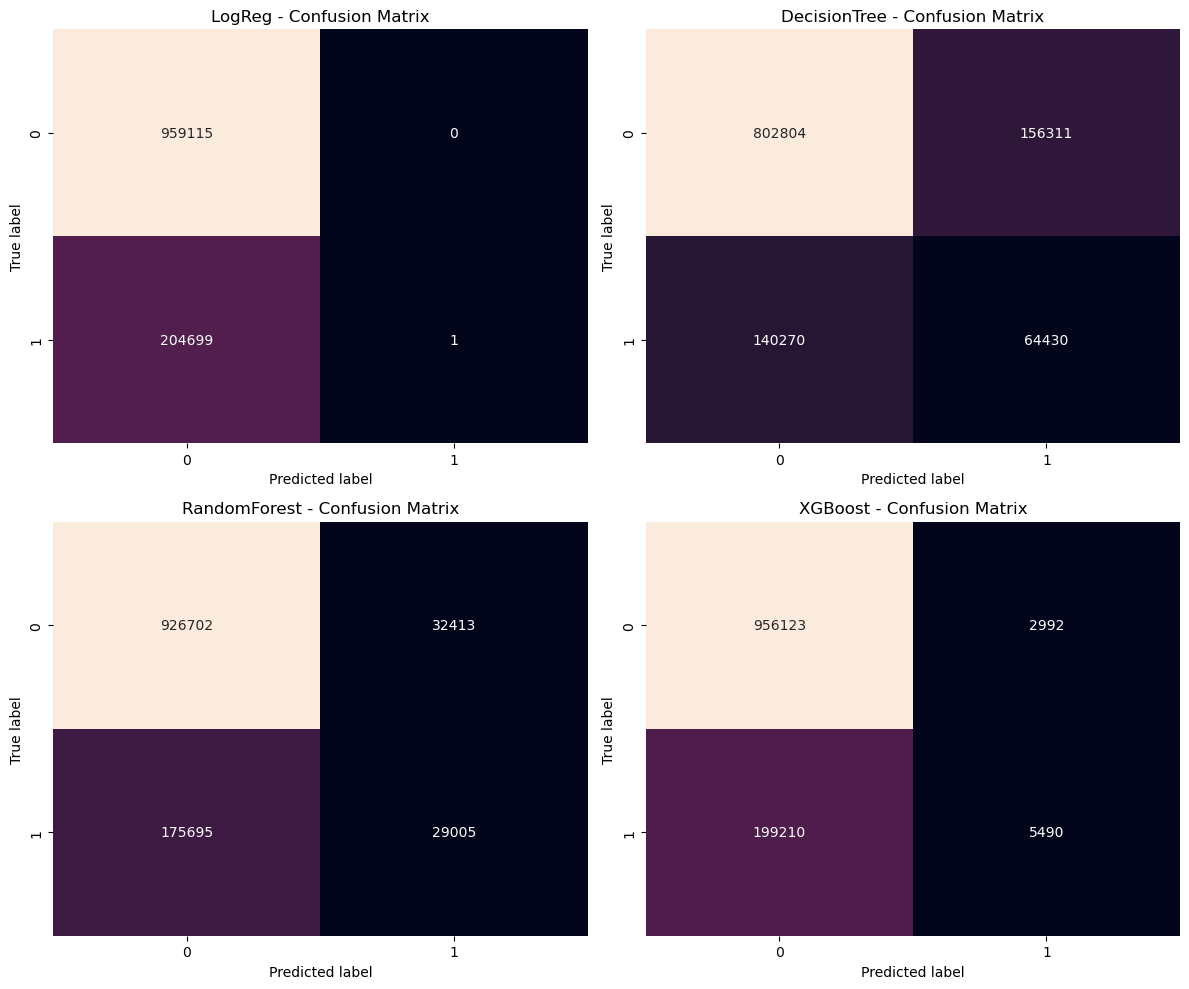

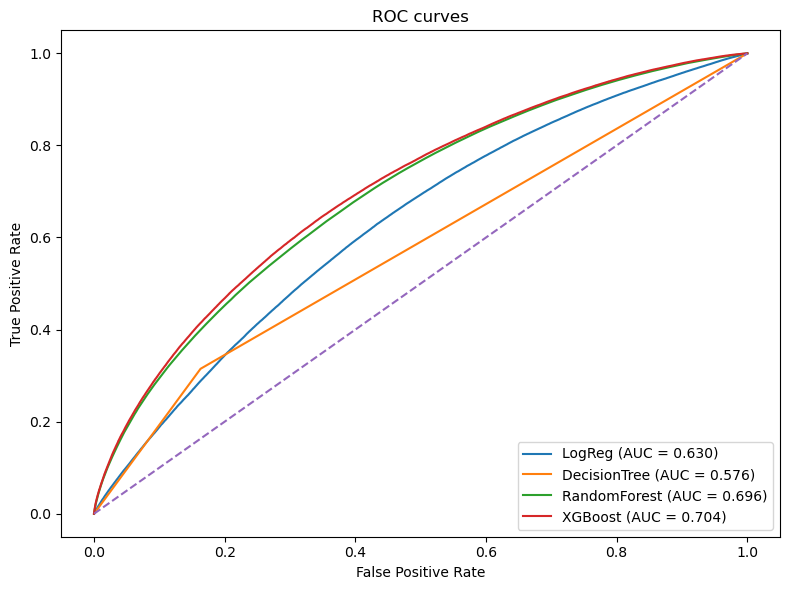

In [114]:

probas = {
    "LogReg": y_proba_logreg,
    "DecisionTree": y_proba_dt,
    "RandomForest": y_proba_rf,
    "XGBoost": y_proba_xgb
}

plt.figure(figsize=(8, 6))

for name, y_proba in probas.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


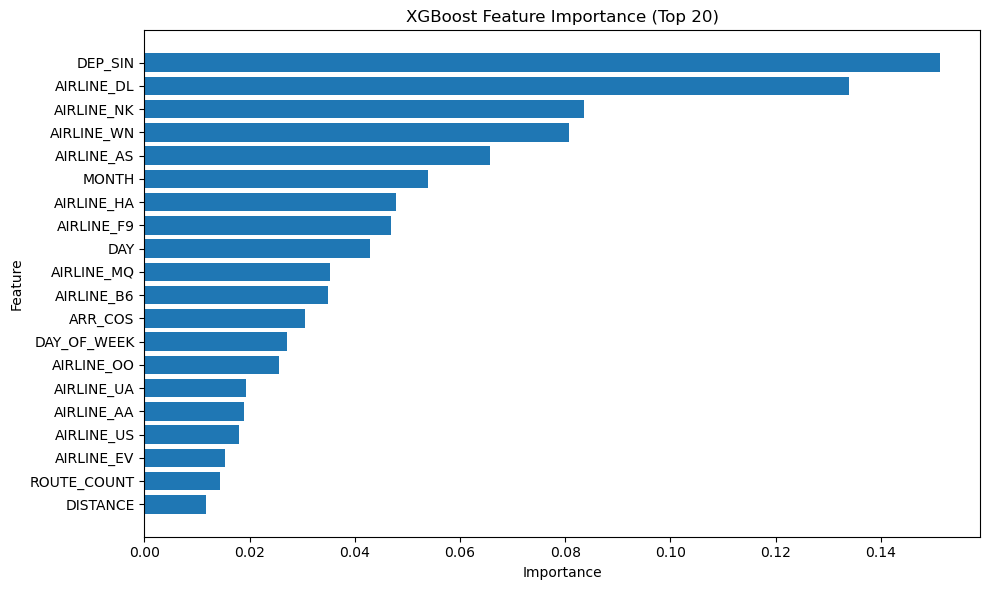

In [115]:

# Extract feature names
raw_feature_names = rf_model.named_steps['preprocess'].get_feature_names_out()

# Clean names
clean_feature_names = [
    name.replace("num__", "").replace("cat__", "")
    for name in raw_feature_names
]

# Extract feature names after preprocessing
feature_names = xgb_model.named_steps['preprocess'].get_feature_names_out()

# Extract raw importances from the classifier
importances = xgb_model.named_steps['clf'].feature_importances_

# Sort from most to least important
indices = np.argsort(importances)[::-1]
sorted_features = np.array(clean_feature_names)[indices]
sorted_importances = importances[indices]

# Plot (Top 20)
plt.figure(figsize=(10, 6))
plt.barh(sorted_features[:20][::-1], sorted_importances[:20][::-1])
plt.title("XGBoost Feature Importance (Top 20)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


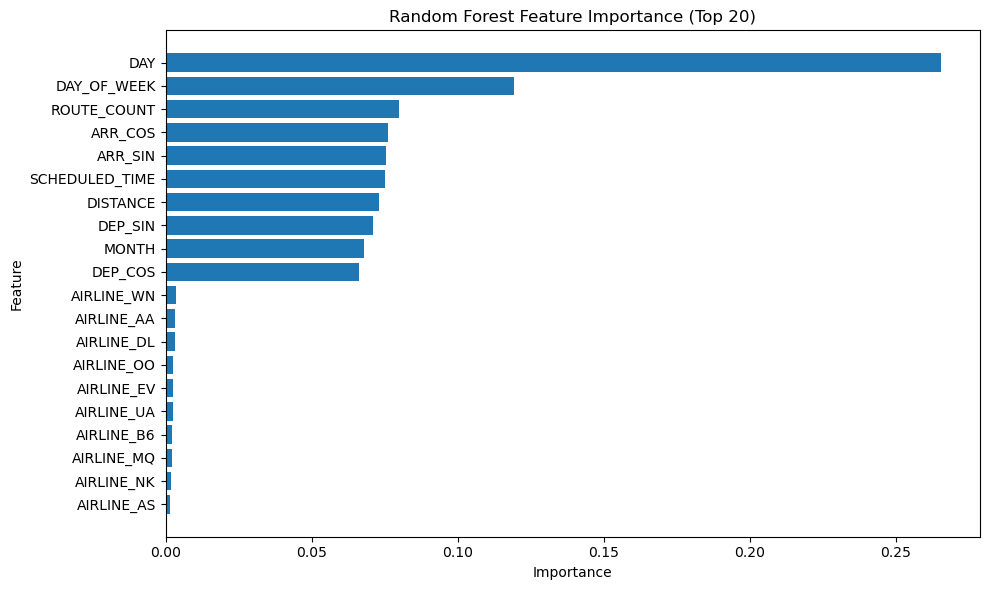

In [116]:

# Extract importances
importances = rf_model.named_steps['clf'].feature_importances_

# Sort
indices = np.argsort(importances)[::-1]
sorted_features = np.array(clean_feature_names)[indices]
sorted_importances = importances[indices]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_features[:20][::-1], sorted_importances[:20][::-1])
plt.title("Random Forest Feature Importance (Top 20)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


### **Model performance analysis**

The results show strong differences in both predictive performance and training time.

Class imbalance strongly affects all models.
Since only ~18% of flights are delayed, accuracy is not a reliable metric:  
a model predicting all flights as “on time” would already reach ~82% accuracy.  
Therefore we are going to look at metrics such as Recall, F1-score and ROC-AUC to provide a more meaningful analysis.

- **Logistic Regression** achieves a high accuracy but completely fails to identify delayed flights  
  (recall ~0). It predicts almost exclusively the majority class.  

- **Decision Tree** shows moderate performance but tends to overfit and remains unstable,  
  with a relatively low ROC-AUC.  

- **Random Forest** slightly improves over the Decision Tree but remains expensive to train  
  (20 minutes), with limited improvements in recall and F1.

- **XGBoost** is the **most effective model**:  
  it obtains the highest ROC-AUC (~0.70) and competitive precision,  
  while maintaining a reasonable training time.  
  Its recall is still low due to the dataset imbalance,  
  but this model clearly learns the underlying structure better than the others.

Overall, XGBoost provides the best compromise between predictive performance, model stability,  
and computational efficiency.

Therefore, we will focus exclusively on improving XGBoost for the rest of the project.


---

## **V. Handling class imbalance**

### 1. scale_pos_weight method

The dataset is highly imbalanced (only ~18% of delayed flights).  
To make XGBoost pay more attention to the minority class, we use the built-in  
`scale_pos_weight` parameter.

This re-weights the loss function so that misclassifying a delayed flight  
is penalized more than misclassifying an on-time flight.


In [69]:

# Compute class distribution on the training set
counter = Counter(y_train)
n_neg, n_pos = counter[0], counter[1]

scale_pos_weight = n_neg / n_pos
print("Class distribution (train):", counter)
print("scale_pos_weight for XGBoost:", scale_pos_weight)


Class distribution (train): Counter({0: 3836460, 1: 818798})
scale_pos_weight for XGBoost: 4.685477981138205


In [70]:

# XGBoost model with class imbalance handling
xgb_bal_model = Pipeline([
    ('preprocess', preprocessor),
    ('clf', XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss',
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight
    ))
])

start = time.time()
xgb_bal_model.fit(X_train, y_train)


# Predictions and probabilities
y_pred_xgb_bal = xgb_bal_model.predict(X_test)
y_proba_xgb_bal = xgb_bal_model.predict_proba(X_test)[:, 1]


xgb_bal_train_time = time.time() - start

# Metrics
xgb_bal_results = {
    "Accuracy": accuracy_score(y_test, y_pred_xgb_bal),
    "Precision": precision_score(y_test, y_pred_xgb_bal),
    "Recall": recall_score(y_test, y_pred_xgb_bal),
    "F1": f1_score(y_test, y_pred_xgb_bal),
    "ROC-AUC": roc_auc_score(y_test, y_proba_xgb_bal),
    "Train_time_s": xgb_bal_train_time
}

print("=== XGBoost with scale_pos_weight ===")
print(f"Balanced XGBoost training time: {xgb_bal_train_time:.2f} s")
print("Accuracy :", xgb_bal_results["Accuracy"])
print("Precision:", xgb_bal_results["Precision"])
print("Recall   :", xgb_bal_results["Recall"])
print("F1-score :", xgb_bal_results["F1"])
print("ROC-AUC  :", xgb_bal_results["ROC-AUC"])

print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb_bal))


Balanced XGBoost training time: 42.94 s
=== XGBoost with scale_pos_weight ===
Training Time : 42.939656257629395
Accuracy : 0.6446772038511276
Precision: 0.2809049591459039
Recall   : 0.6539912066438691
F1-score : 0.3930048702871385
ROC-AUC  : 0.7041158939443343

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.64      0.75    959115
           1       0.28      0.65      0.39    204700

    accuracy                           0.64   1163815
   macro avg       0.59      0.65      0.57   1163815
weighted avg       0.79      0.64      0.69   1163815



### 2. SMOTE method

While class weighting is an effective way to make XGBoost more sensitive to the
minority class, it does not modify the underlying distribution of the training
data. To complement this approach, we also evaluate **SMOTE (Synthetic Minority
Oversampling Technique)**, a popular method that generates synthetic samples for
the minority class by interpolating between existing observations.

SMOTE is applied **only to the training set**, after preprocessing, to avoid any
information leakage into the test data. We train a third XGBoost model using this
oversampled dataset and compare its performance to both the baseline model and
the class-weighted version. This allows us to assess how different imbalance-handling
strategies impact recall, precision, and overall discrimination capability.


In [76]:

# SMOTE + XGBoost pipeline
xgb_smote_model = ImbPipeline([
    ('preprocess', preprocessor),       # same preprocessing as baseline
    ('smote', SMOTE(random_state=42)),  # oversample minority class
    ('clf', XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss',
        n_jobs=-1,
    ))
])

# Train the SMOTE-augmented model
start = time.time()
xgb_smote_model.fit(X_train, y_train)


# Predictions
y_pred_xgb_smote = xgb_smote_model.predict(X_test)
y_proba_xgb_smote = xgb_smote_model.predict_proba(X_test)[:, 1]
xgb_smote_train_time = time.time() - start

# Metrics
xgb_smote_results = {
    "Accuracy": accuracy_score(y_test, y_pred_xgb_smote),
    "Precision": precision_score(y_test, y_pred_xgb_smote),
    "Recall": recall_score(y_test, y_pred_xgb_smote),
    "F1": f1_score(y_test, y_pred_xgb_smote),
    "ROC-AUC": roc_auc_score(y_test, y_proba_xgb_smote),
    "Train_time_s": xgb_smote_train_time
}


print("=== XGBoost with SMOTE ===")
print(f"SMOTE XGBoost training time: {xgb_smote_train_time:.2f} s")
print("Accuracy :", xgb_smote_results["Accuracy"])
print("Precision:", xgb_smote_results["Precision"])
print("Recall   :", xgb_smote_results["Recall"])
print("F1-score :", xgb_smote_results["F1"])
print("ROC-AUC  :", xgb_smote_results["ROC-AUC"])

print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb_smote))



=== XGBoost ===
SMOTE XGBoost training time: 721.05 s
Accuracy : 0.7657875177755915
Precision: 0.33859462235707016
Recall   : 0.3478212017586712
F1-score : 0.3431459017104521
ROC-AUC  : 0.6803809908051609

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.85      0.86    959115
           1       0.34      0.35      0.34    204700

    accuracy                           0.77   1163815
   macro avg       0.60      0.60      0.60   1163815
weighted avg       0.77      0.77      0.77   1163815



In [77]:

xgb_full_compare = pd.DataFrame({
    "Baseline": xgb_results,
    "ClassWeight": xgb_bal_results,
    "SMOTE": xgb_smote_results
}).T

xgb_full_compare


,Accuracy,Precision,Recall,F1,ROC-AUC,Train_time_s
Baseline,0.826259,0.647253,0.026820,0.051505,0.703998,45.711643
ClassWeight,0.644677,0.280905,0.653991,0.393005,0.704116,42.939656
SMOTE,0.765788,0.338595,0.347821,0.343146,0.680381,721.047549


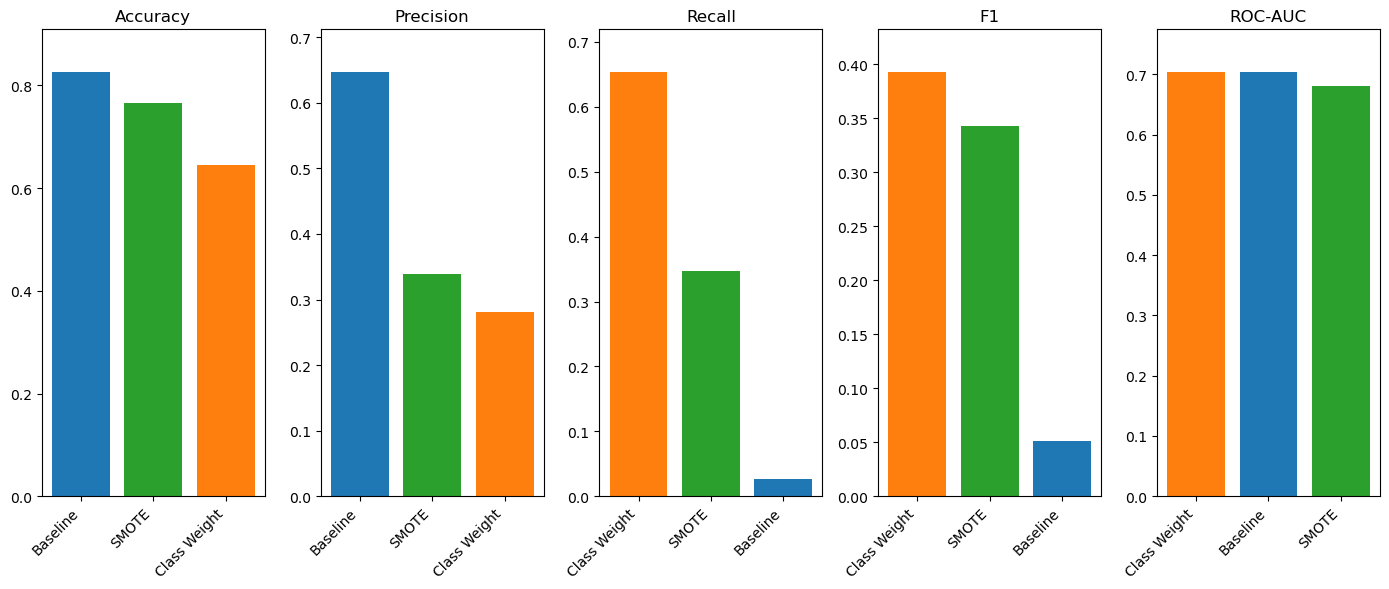

In [124]:

metrics = ["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"]

models = ["Baseline", "Class Weight", "SMOTE"]
values = {
    "Baseline":     [xgb_results[m] for m in metrics],
    "Class Weight": [xgb_bal_results[m] for m in metrics],
    "SMOTE":        [xgb_smote_results[m] for m in metrics]
}

colors = {
    "Baseline": "#1f77b4",
    "Class Weight": "#ff7f0e",
    "SMOTE": "#2ca02c"
}


plt.figure(figsize=(14, 6))

for i, metric in enumerate(metrics):
    metric_values = [
        values["Baseline"][i],
        values["Class Weight"][i],
        values["SMOTE"][i]
    ]
    
    sorted_idx = np.argsort(metric_values)[::-1]
    sorted_vals = [metric_values[j] for j in sorted_idx]
    sorted_labels = [models[j] for j in sorted_idx]
    
    plt.subplot(1, len(metrics), i+1)
    plt.bar(sorted_labels, sorted_vals, 
            color=[colors[label] for label in sorted_labels])
    
    plt.title(metric)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, max(sorted_vals) * 1.1)

plt.tight_layout()
plt.show()



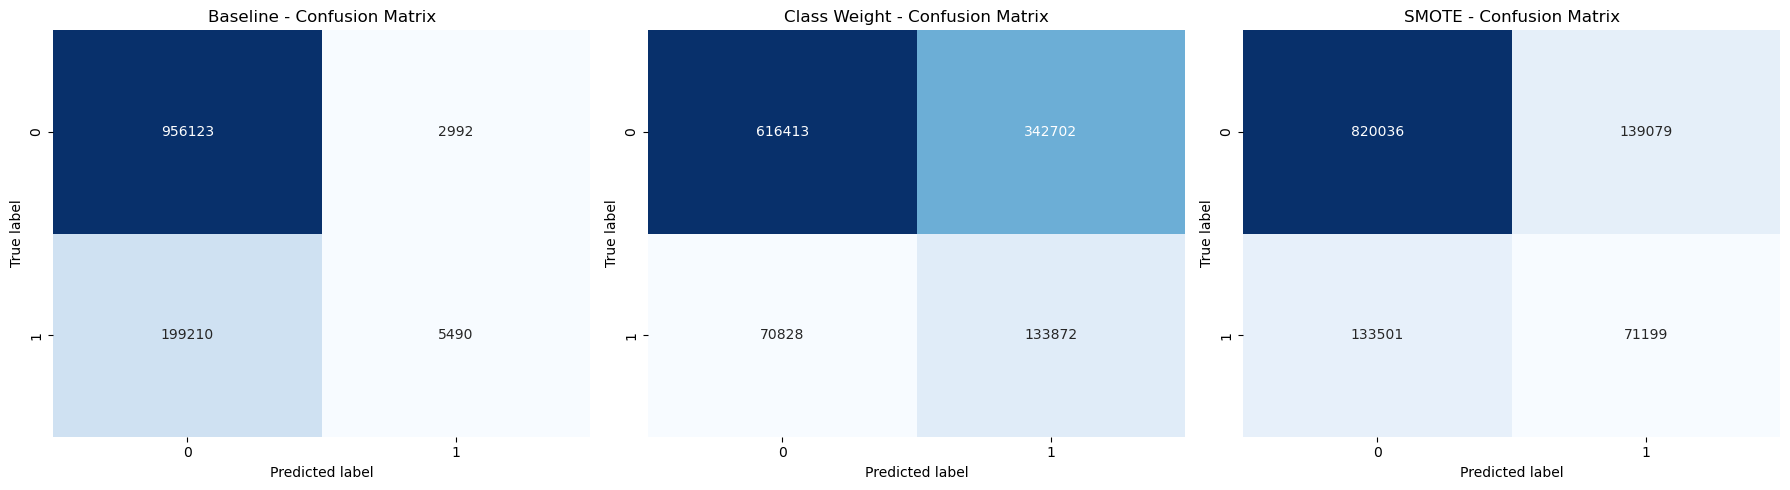

In [79]:

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_preds = [
    ("Baseline", y_pred_xgb),
    ("Class Weight", y_pred_xgb_bal),
    ("SMOTE", y_pred_xgb_smote)
]

for ax, (name, preds_) in zip(axes, models_preds):
    cm = confusion_matrix(y_test, preds_)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(f"{name} - Confusion Matrix")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

plt.tight_layout()
plt.show()


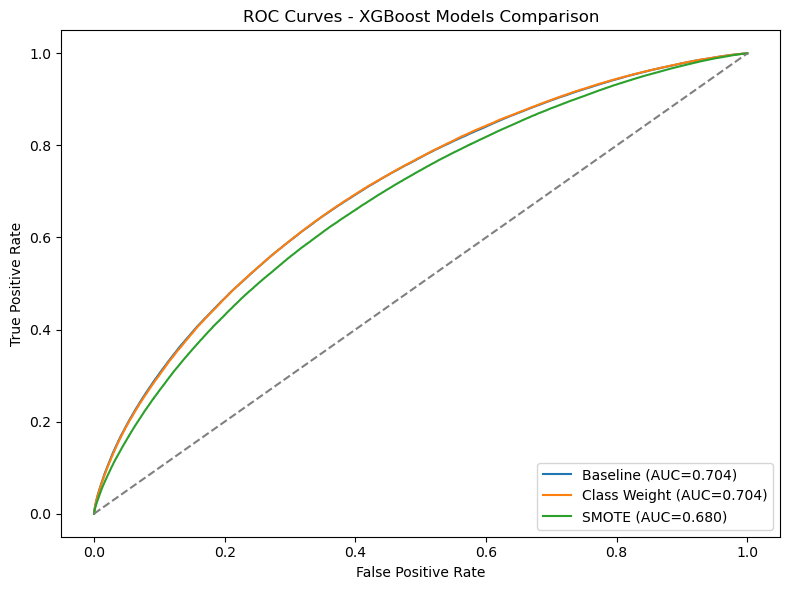

In [80]:

plt.figure(figsize=(8, 6))

for name, proba in [
    ("Baseline", y_proba_xgb),
    ("Class Weight", y_proba_xgb_bal),
    ("SMOTE", y_proba_xgb_smote)
]:
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - XGBoost Models Comparison")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


### **Analysis of imbalance-handling strategies for XGBoost**

Three XGBoost models were compared:

1. **Baseline XGBoost** 
2. **XGBoost with class weighting** (`scale_pos_weight`)  
3. **XGBoost combined with SMOTE oversampling**

The results highlight three very distinct behaviors:

**Baseline XGBoost** achieves the highest accuracy and good precision, but its recall is extremely low.
The model almost never predicts the minority class, despite a solid ROC-AUC. This confirms that accuracy
alone is misleading on imbalanced data: without specific imbalance handling, the classifier learns to
predict the majority class most of the time.

**Class-weighted XGBoost** dramatically increases recall (from ~3% to ~65%) while maintaining the same
ROC-AUC as the baseline. The F1-score improves significantly, and training time remains comparable.
This shows that reweighting the loss function is an efficient and computationally inexpensive way to
force the model to pay more attention to delayed flights.

**XGBoost with SMOTE** also improves recall but does not outperform the class-weighted version.
Also, training time increases drastically due to oversampling in a high-dimensional feature space,
and ROC-AUC slightly decreases. This suggests that SMOTE introduces noise and is less suitable for this dataset.
  
Class weighting provides the best trade-off between recall, precision, F1-score, ROC-AUC and computation
time. It is therefore selected as the preferred imbalance-handling strategy for the rest of the project.


---

## **VI. Model Optimization**

After selecting the class-weighted XGBoost model as the best-performing approach,
the final step consists in optimizing the model to improve its predictive power

### 1. Decision threshold tuning

In [200]:

# Probability of class-weighted model
y_scores = y_proba_xgb_bal

prec, rec, thresholds = precision_recall_curve(y_test, y_scores)

# Compute F1 for each threshold
f1_values = 2 * (prec * rec) / (prec + rec + 1e-8)
best_idx = f1_values.argmax()

best_threshold = thresholds[best_idx]
best_f1 = f1_values[best_idx]

print("Best threshold:", best_threshold)
print("Best F1:", best_f1)
print("Precision at best threshold:", prec[best_idx])
print("Recall at best threshold:", rec[best_idx])


Best threshold: 0.5305306
Best F1: 0.39593839266602043
Precision at best threshold: 0.299458048875777
Recall at best threshold: 0.5841377625793844


In [86]:

y_pred_thresh = (y_scores >= best_threshold).astype(int)
print(classification_report(y_test, y_pred_thresh))


              precision    recall  f1-score   support

           0       0.89      0.71      0.79    959115
           1       0.30      0.58      0.40    204700

    accuracy                           0.69   1163815
   macro avg       0.59      0.65      0.59   1163815
weighted avg       0.79      0.69      0.72   1163815



In [88]:

param_dist = {
    "clf__max_depth": [4, 5, 6, 7, 8],
    "clf__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "clf__n_estimators": [150, 200, 300, 400],
    "clf__subsample": [0.7, 0.8, 0.9, 1.0],
    "clf__colsample_bytree": [0.7, 0.8, 0.9, 1.0],
    "clf__gamma": [0, 0.5, 1],
}

search = RandomizedSearchCV(
    estimator=xgb_bal_model,
    param_distributions=param_dist,
    n_iter=15,                  # keep reasonable
    scoring="f1",               # or "roc_auc"
    cv=3,                       # 3-fold CV
    verbose=2,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)

print("Best params:", search.best_params_)
print("Best score:", search.best_score_)


Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best params: {'clf__subsample': 1.0, 'clf__n_estimators': 150, 'clf__max_depth': 8, 'clf__learning_rate': 0.2, 'clf__gamma': 0.5, 'clf__colsample_bytree': 1.0}
Best score: 0.40902920385714897


In [92]:

best_xgb_model = search.best_estimator_

y_pred_best = best_xgb_model.predict(X_test)
y_proba_best = best_xgb_model.predict_proba(X_test)[:, 1]

best_xgb_results = {
    "Accuracy": accuracy_score(y_test, y_pred_best),
    "Precision": precision_score(y_test, y_pred_best),
    "Recall": recall_score(y_test, y_pred_best),
    "F1": f1_score(y_test, y_pred_best),
    "ROC-AUC": roc_auc_score(y_test, y_proba_best),
}


print("=== BEST XGBoost ===")
print("Accuracy :", best_xgb_results["Accuracy"])
print("Precision:", best_xgb_results["Precision"])
print("Recall   :", best_xgb_results["Recall"])
print("F1-score :", best_xgb_results["F1"])
print("ROC-AUC  :", best_xgb_results["ROC-AUC"])

print("\nClassification Report:\n", classification_report(y_test, y_pred_best))


=== BEST XGBoost ===
Accuracy : 0.6671472699698835
Precision: 0.2983225840639966
Recall   : 0.6600390815828041
F1-score : 0.41091911636118666
ROC-AUC  : 0.7247495008406487

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.67      0.77    959115
           1       0.30      0.66      0.41    204700

    accuracy                           0.67   1163815
   macro avg       0.60      0.66      0.59   1163815
weighted avg       0.80      0.67      0.71   1163815



In [125]:

# Comparison dataframe
xgb_tune_compare = pd.DataFrame({
    "Before_Tuning": xgb_bal_results,
    "After_Tuning": best_xgb_results
}).T

xgb_tune_compare


,Accuracy,Precision,Recall,F1,ROC-AUC,Train_time_s
Before_Tuning,0.644677,0.280905,0.653991,0.393005,0.704116,42.939656
After_Tuning,0.667147,0.298323,0.660039,0.410919,0.724750,NaN


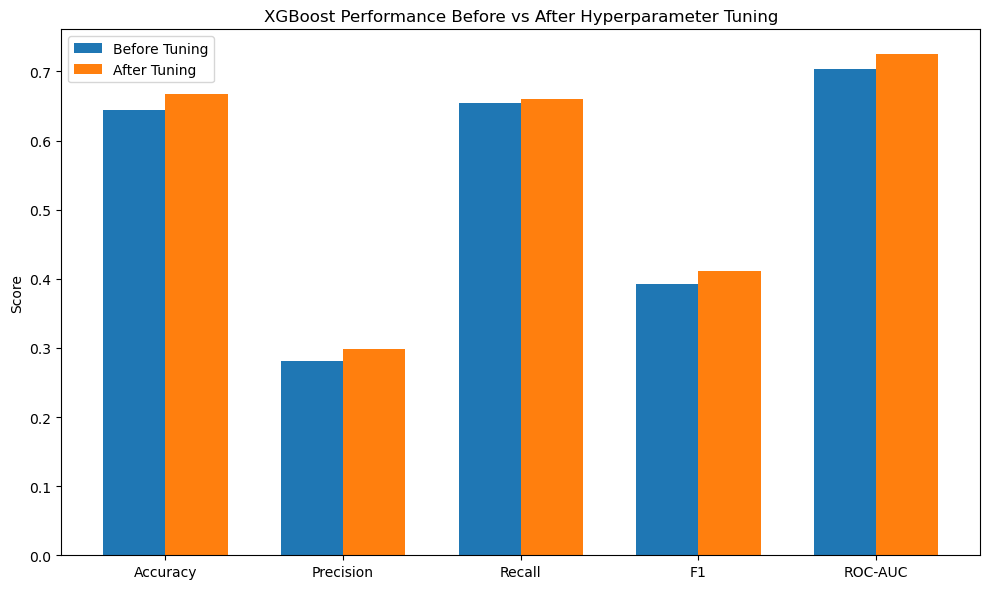

In [97]:

metrics = ["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"]

before = [xgb_bal_results[m] for m in metrics]
after  = [best_xgb_results[m] for m in metrics]

x = np.arange(len(metrics))  # positions des métriques
width = 0.35                 # largeur des barres

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, before, width, label="Before Tuning")
plt.bar(x + width/2, after, width, label="After Tuning")

plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("XGBoost Performance Before vs After Hyperparameter Tuning")
plt.legend()
plt.tight_layout()
plt.show()


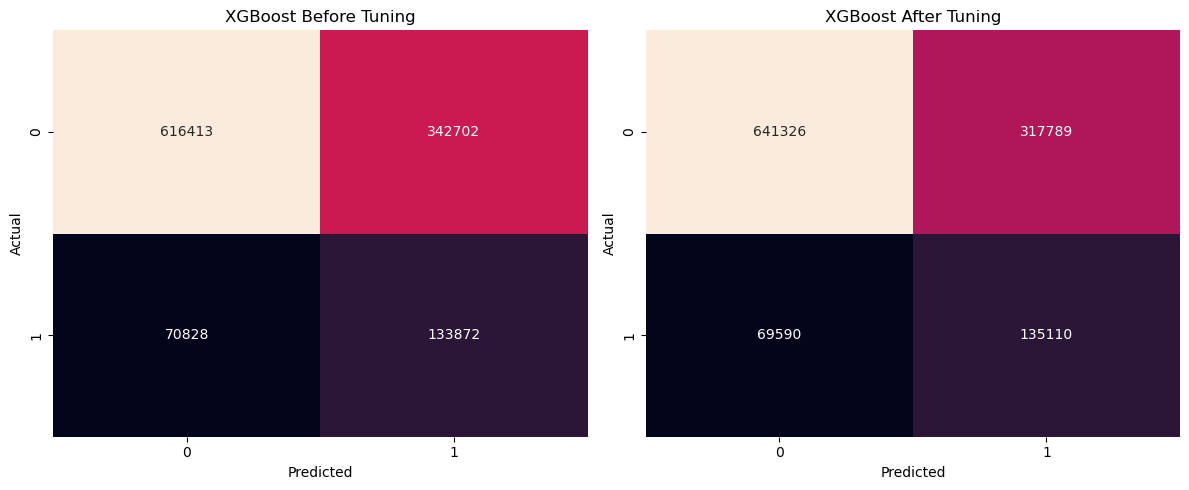

In [95]:

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before tuning
cm_before = confusion_matrix(y_test, y_pred_xgb_bal)
sns.heatmap(cm_before, annot=True, fmt="d", cbar=False, ax=axes[0])
axes[0].set_title("XGBoost Before Tuning")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# After tuning
cm_after = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm_after, annot=True, fmt="d", cbar=False, ax=axes[1])
axes[1].set_title("XGBoost After Tuning")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()


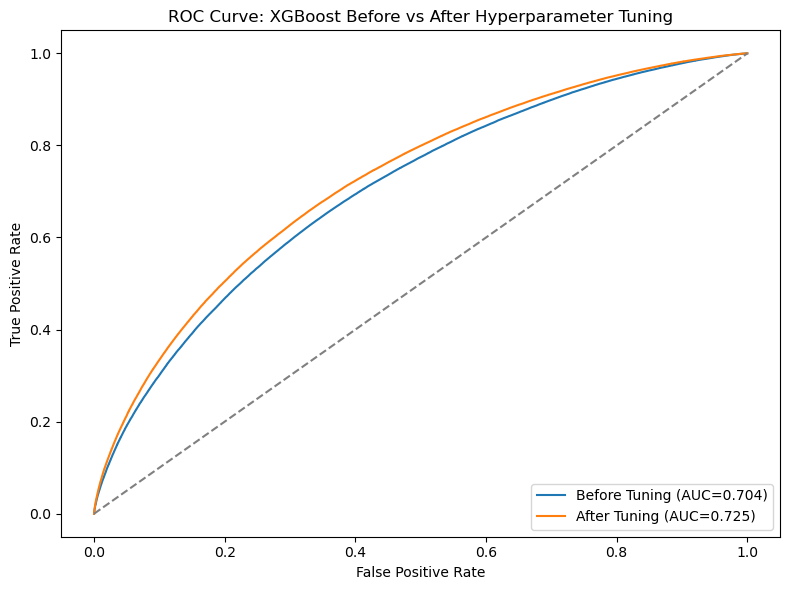

In [96]:

# Compute ROC curves
fpr_before, tpr_before, _ = roc_curve(y_test, y_proba_xgb_bal)
fpr_after, tpr_after, _ = roc_curve(y_test, y_proba_best)

plt.figure(figsize=(8, 6))

plt.plot(fpr_before, tpr_before, label=f"Before Tuning (AUC={xgb_bal_results['ROC-AUC']:.3f})")
plt.plot(fpr_after, tpr_after, label=f"After Tuning (AUC={best_xgb_results['ROC-AUC']:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.title("ROC Curve: XGBoost Before vs After Hyperparameter Tuning")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


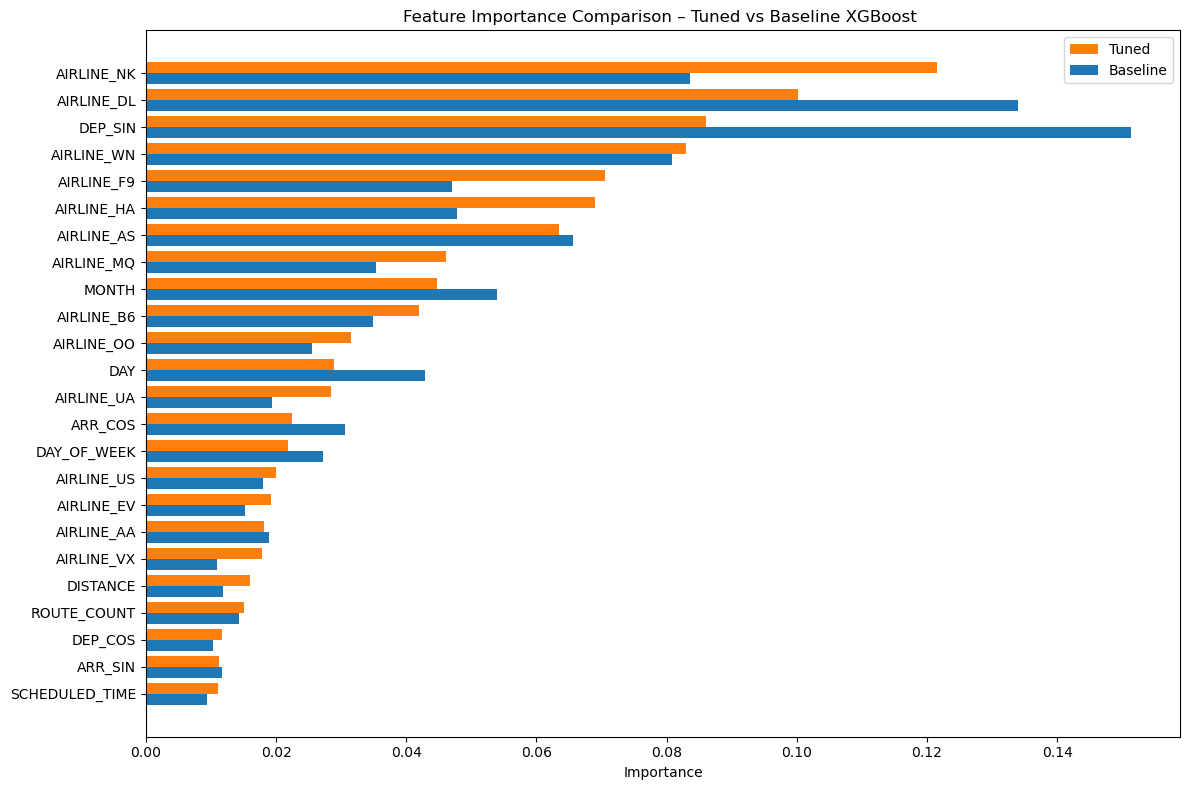

In [126]:

# Importances for both models (same feature order)
baseline_importances = xgb_model.named_steps['clf'].feature_importances_
tuned_importances = best_xgb_model.named_steps['clf'].feature_importances_

# DataFrame for easier manipulation
imp_df = pd.DataFrame({
    "Feature": clean_feature_names,
    "Baseline": baseline_importances,
    "Tuned": tuned_importances
})

# Sort by Tuned model importance only
imp_df_sorted = imp_df.sort_values("Tuned", ascending=False).head(50)

# Plot grouped bars (horizontal)
plt.figure(figsize=(12, 8))

y_pos = np.arange(len(imp_df_sorted))
bar_width = 0.4

plt.barh(y_pos - bar_width/2, imp_df_sorted["Tuned"],
         height=bar_width, label="Tuned", color="#ff7f0e")

plt.barh(y_pos + bar_width/2, imp_df_sorted["Baseline"],
         height=bar_width, label="Baseline", color="#1f77b4")

# Format
plt.yticks(y_pos, imp_df_sorted["Feature"])
plt.gca().invert_yaxis()  # highest at the top
plt.xlabel("Importance")
plt.title("Feature Importance Comparison – Tuned vs Baseline XGBoost ")
plt.legend()
plt.tight_layout()
plt.show()



### Analysis of Hyperparameter Tuning

The hyperparameter tuning procedure applied to the class‐weighted XGBoost model
led to measurable improvements across all relevant metrics. The comparison between
the original model and the optimized one is summarized below:

| Metric        | Before Tuning | After Tuning |
|---------------|--------------:|-------------:|
| Accuracy      | 0.6447        | **0.6671**   |
| Precision     | 0.2809        | **0.2983**   |
| Recall        | 0.6540        | **0.6600**   |
| F1-score      | 0.3930        | **0.4109**   |
| ROC-AUC       | 0.7041        | **0.7248**   |

Several observations can be made:

1. **Improved F1-score (+4.6%)**  
   The optimized model achieves a higher F1-score, meaning it strikes a better
   balance between precision and recall. This is particularly important for the
   minority class (delayed flights), where both false negatives and false positives
   carry operational consequences.

2. **Recall remains high and slightly increases**  
   The recall increases from 0.654 to 0.660, confirming that the tuned model is
   equally capable—or slightly better—at identifying delayed flights. Maintaining
   a high recall is a primary objective in this project.

3. **Precision increases as well (+6.2%)**  
   Unlike many imbalance treatments that improve recall at the cost of precision,
   the tuned model improves both. This indicates that the hyperparameters selected
   help the classifier produce more reliable positive predictions.

4. **Significant improvement in ROC-AUC (+2.1%)**  
   ROC-AUC increases from 0.704 to 0.725, suggesting the model has better overall
   discrimination ability across thresholds. This confirms that performance gains
   are not simply due to changing the prediction threshold but result from a
   genuinely improved decision boundary.


5. **The distribution of feature importances becomes more homogeneous after tuning.**  
  The baseline model tends to rely heavily on a small subset of dominant
  features, while the tuned model distributes importance more evenly across
  predictors. This typically indicates stronger regularization, better sampling
  and more diverse trees. A more homogeneous importance structure often implies improved generalization and
  reduced overfitting, as the model no longer depends excessively on a few
  specific patterns.

7. **Accuracy improves but remains a secondary metric**  
   Accuracy rises from 0.645 to 0.667. While this is expected, it is not central
   to evaluating imbalanced classification problems and should be interpreted
   cautiously.

Overall, **hyperparameter tuning successfully enhanced model performance on all
key evaluation criteria**. The tuned XGBoost model offers better generalization,
higher discriminative power, and a more effective trade-off between precision
and recall. It therefore represents the best version of the model and will be
used as the final classifier in the project.
